<img title="GitHub Octocat" src='./img/Octocat.jpg?raw=true' style='height: 60px; padding-right: 15px' alt="Octocat" align="left"> This notebook is part of a GitHub repository: https://github.com/pessini/european-voters 
<br>MIT Licensed
<br>Author: Leandro Pessini

# <p style="background-color:#003399; font-family:tahoma; font-size:120%; text-align:left; color:#FFCC00; padding: 15px 5px 15px 25px; border-radius: 15px;">Examining factors that influence EU acceptance among European voters</p>
    
## Would you vote for your country to leave or remain in the European Union?

<img src='./img/brexit.jpeg' style='height:400px'/>

Photo: The Irish Times — [BREXIT: THE FACTS](https://www.irishtimes.com/news/world/brexit/brexit-the-facts)

# <p style="background-color:#003399; font-family:tahoma; font-size:120%; text-align:left; color:#FFCC00; padding: 15px 5px 15px 25px; border-radius: 15px;">Table of Contents:</p>

* [1. Introduction](#1)
    * [1.1 Data Dictionary](#1.1)
    * [1.2 Survey Questions](#1.2)
    * [1.3 International Standard Classification of Education (ISCED)](#1.3)
    * [1.4 Notebook settings](#1.4)
    * [1.5 Libraries](#1.5)
    * [1.6 Loading Dataset](#1.6)
* [2. Data Cleaning & Wrangling](#2)
    * [2.1 Handle Missings](#2.1)
    * [2.2 Data Transformation / Aggregation](#2.2)
    * [2.3 European Regions](#2.3)
* [3. Survey Weights](#3)
* [4. Exploratory Data Analysis](#4)
    * [4.1 European Union Views](#4.1)
    * [4.2 Gender-Age Analysis](#4.2)
    * [4.3 Age Overview by Voting Intention](#4.3)
    * [4.4 Education Overview](#4.4)
    * [4.5 Unemployment rate](#4.5)
    * [4.6 Union Membership](#4.6)
* [5. Relation between Education and Voting Intentions](#5)
    * [5.1 Logistic Regression](#5.1)
    * [5.2 Predicted probability of voting to Leave the EU](#5.2)
* [6. Conclusion](#6)
* [7. References](#7)


<a id="1"></a>
# <p style="background-color:#003399; font-family:tahoma; font-size:120%; text-align:left; color:#FFCC00; padding: 15px 5px 15px 25px; border-radius: 15px;">1- Introduction</p>

<img title="European Social Survey" src="img/ess_logo.png" alt="European Social Survey (ESS)" align="right"> This analysis will investigate a dataset provided by [European Social Survey (ESS)](https://www.europeansocialsurvey.org/) which is a cross-national survey of attitudes and behaviour from European citizens. The topics covered by ESS are very heterogeneous and include media and social trust, politics, immigration, citizen involvement, health and care, economic, work and well-being.

The focus will be on which aspects can influence a person to vote for their country to leave or remain a member of the European Union. The variables selected are mostly socio-demographic such as education, employment status and Union membership status. 


<a id='1.1'></a>
## Data Dictionary

- __CNTRY__ Country
- __EDUYRS__ Years of full-time education completed
- __EISCED__ Highest level of education, ES - ISCED
- __UEMP3M__ Ever unemployed and seeking work for a period more than three months
- __MBTRU__ Member of trade union or similar organisation
- __VTEURMMB__ Would vote for your country to remain member of European Union or leave
- __GNDR__ Gender
- __YRBRN__  Year of birth
- __AGEA__ Age of respondent. Calculation based on year of birth and year of interview

<a id='1.2'></a>
## Survey Questions

**EDUYR** About how many years of education have you completed, whether full-time or part-time? Please report these in full-time equivalents and include compulsory years of schooling.
<br>**EISCED** Generated variable: Highest level of education, ES - ISCED 9 (What is the highest level of education you have successfully completed?)
<br>**UEMP3M** Have you ever been unemployed and seeking work for a period of more than three months?
<br>**MBTRU** Are you or have you ever been a member of a trade union or similar organisation? IF YES, is that currently or previously?
<br>**VTEURMMB** Imagine there were a referendum in [country] tomorrow about membership of the European Union. Would you vote for [country] to remain a member of the European Union or to leave the European Union?
<br>**YRBRN** And in what year were you born?

<a id='1.3'></a>
## International Standard Classification of Education (ISCED)

ISCED is the reference international classification for organising education programmes and related qualifications by levels and fields. ISCED 2011 (levels of education) has been implemented in all EU data collections
since 2014.

__Levels__

- ISCED 0: Early childhood education (‘less than primary’ for educational attainment)
- ISCED 1: Primary education
- ISCED 2: Lower secondary education
- ISCED 3: Upper secondary education
- ISCED 4: Post-secondary non-tertiary education
- ISCED 5: Short-cycle tertiary education
- ISCED 6: Bachelor’s or equivalent level
- ISCED 7: Master’s or equivalent level
- ISCED 8: Doctoral or equivalent level

More info about ISCED can be found [here](https://ec.europa.eu/eurostat/statistics-explained/index.php/International_Standard_Classification_of_Education_(ISCED)).

<a id='1.4'></a>
## Notebook settings

In [1]:
# Change the default plots size 
options(repr.plot.width=15, repr.plot.height=10)
options(warn=-1)
# Suppress summarise info
options(dplyr.summarise.inform = FALSE)

<a id='1.5'></a>
## Libraries

In [2]:
# Check if the packages that we need are installed
want = c("dplyr", "ggplot2", "ggthemes", "gghighlight", "foreign", "scales", "survey", "srvyr", "caret", 
         "ggpubr", "forcats")
have = want %in% rownames(installed.packages())
# Install the packages that we miss
if ( any(!have) ) { install.packages( want[!have] ) }
# Load the packages
junk <- lapply(want, library, character.only = T)
# Remove the objects we created
rm(have, want, junk)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: grid

Loading required package: Matrix

Loading required package: survival


Attaching package: ‘survey’


The following object is masked from ‘package:graphics’:

    dotchart



Attaching package: ‘srvyr’


The following object is masked from ‘package:stats’:

    filter


Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:survival’:

    cluster




<a id='1.6'></a>
## Loading dataset

__Selecting the variables which will be used for the data analysis__

In [3]:
survey_rawdata <- read.spss("ESS9e03_1.sav", use.value.labels=T, max.value.labels=Inf, to.data.frame=TRUE)

In [4]:
variables <- c("cntry", 
               "eduyrs", 
               "eisced",
               "uemp3m", 
               "mbtru", 
               "vteurmmb", 
               "yrbrn", 
               "agea", 
               "gndr", 
               "anweight", 
               "psu", 
               "stratum")

In [5]:
european_survey <- survey_rawdata[,variables]

In [6]:
head(european_survey)

,cntry,eduyrs,eisced,uemp3m,mbtru,vteurmmb,yrbrn,agea,gndr,anweight,psu,stratum
,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>
1,Austria,12,"ES-ISCED IIIb, lower tier upper secondary",No,No,Remain member of the European Union,1975,43,Male,0.06588958,1688,59
2,Austria,12,"ES-ISCED IIIb, lower tier upper secondary",No,"Yes, previously",Remain member of the European Union,1951,67,Male,0.12490674,88,79
3,Austria,12,"ES-ISCED II, lower secondary",No,No,Leave the European Union,1978,40,Female,0.68583600,938,11
4,Austria,11,"ES-ISCED IIIb, lower tier upper secondary",No,No,Remain member of the European Union,1955,63,Male,0.11675334,1998,74
5,Austria,8,"ES-ISCED II, lower secondary",No,No,Remain member of the European Union,1947,71,Female,0.31178924,601,99
6,Austria,13,"ES-ISCED IIIb, lower tier upper secondary",No,"Yes, previously",Remain member of the European Union,1954,64,Male,0.17386711,68,77


In [7]:
paste0("Number of rows in the dataset: ", nrow(european_survey))

[1] "Number of rows in the dataset: 49519"

<a id="2"></a>
# <p style="background-color:#003399; font-family:tahoma; font-size:120%; text-align:left; color:#FFCC00; padding: 15px 5px 15px 25px; border-radius: 15px;">2- Data Cleaning & Wrangling</p>

In [8]:
# Checking for NA's in the dataset
sapply(european_survey, function(x) sum(is.na(x)))

cntry   eduyrs   eisced   uemp3m    mbtru vteurmmb    yrbrn     agea 
       0      708      107      295      331    13648      222      222 
    gndr anweight      psu  stratum 
       0        0        0        0

<a id='2.1'></a>
## Handle Missings

In [9]:
# For the purpose of this analysis, considering Vote as Leave or Remain
european_survey$vteurmmb <- as.character(european_survey$vteurmmb)
european_survey$vteurmmb[european_survey$vteurmmb == "Remain member of the European Union"] <- "Remain"
european_survey$vteurmmb[european_survey$vteurmmb == "Leave the European Union"] <- "Leave"
european_survey$vteurmmb[european_survey$vteurmmb == "Would submit a blank ballot paper"] <- NA
european_survey$vteurmmb[european_survey$vteurmmb == "Would spoil the ballot paper"] <- NA
european_survey$vteurmmb[european_survey$vteurmmb == "Would not vote"] <- NA
european_survey$vteurmmb[european_survey$vteurmmb == "Not eligible to vote"] <- NA
european_survey$vteurmmb <- as.factor(european_survey$vteurmmb)

In [10]:
# Cleaning responses that are not able to fit into ISCED
european_survey$eisced <- as.character(european_survey$eisced)
european_survey$eisced[european_survey$eisced == "Not possible to harmonise into ES-ISCED"] <- NA
european_survey$eisced[european_survey$eisced == "Other"] <- NA

In [11]:
# Cleaning NA values
df_european_survey <- european_survey[complete.cases(european_survey), ]
sapply(df_european_survey, function(x) sum(is.na(x)))

cntry   eduyrs   eisced   uemp3m    mbtru vteurmmb    yrbrn     agea 
       0        0        0        0        0        0        0        0 
    gndr anweight      psu  stratum 
       0        0        0        0

In [12]:
# Different way to clean the variable leaving as yes or no
df_european_survey$uemp3m <- as.character(df_european_survey$uemp3m)
df_european_survey$uemp3m <- as.factor(df_european_survey$uemp3m)

<a id='2.2'></a>
## Data Transformation / Aggregation
### Aggregating Education Levels by EISCED

| Level            | ISCED      |
| :-----------:    |:----------:|
| Low education    | Levels 0-2 |
| Medium education | Levels 3-4 |
| High education   | Levels 5-8 |

In [13]:
# Creating a new feature Education by aggregating the ISCED"s levels
# Low, Medium and High Education
df_european_survey <- df_european_survey %>% 
  mutate(Education = case_when(
      eisced == "ES-ISCED I , less than lower secondary" ~ "Low Education",
      eisced == "ES-ISCED II, lower secondary" ~ "Low Education",
      eisced == "ES-ISCED IIIb, lower tier upper secondary" ~ "Medium Education",
      eisced == "ES-ISCED IIIa, upper tier upper secondary" ~ "Medium Education",
      eisced == "ES-ISCED IV, advanced vocational, sub-degree" ~ "Medium Education",
      eisced == "ES-ISCED V1, lower tertiary education, BA level" ~ "High Education",
      eisced == "ES-ISCED V2, higher tertiary education, >= MA level" ~ "High Education",
      TRUE ~ eisced))
df_european_survey$Education <- as.factor(df_european_survey$Education)
df_european_survey$eisced <- as.factor(df_european_survey$eisced)

In [14]:
# For the purpose of this analysis, considering the answer if the respondent ever been a member 
# of a trade union or similar organisation - "Yes, currently" and "Yes, previously" as simple Yes
df_european_survey$mbtru <- as.character(df_european_survey$mbtru)
df_european_survey$mbtru[df_european_survey$mbtru == "Yes, currently"] <- "Yes"
df_european_survey$mbtru[df_european_survey$mbtru == "Yes, previously"] <- "Yes"
df_european_survey$mbtru <- as.factor(df_european_survey$mbtru)


In [15]:
# Transforming as numeric the variable Years of Education
df_european_survey$eduyrs <- as.numeric(df_european_survey$eduyrs)

In [16]:
# Creating a new feature as per age (eg. young, young adult, older adult, elderly)
df_european_survey$agea <- as.numeric(df_european_survey$agea)
df_european_survey <- df_european_survey %>% 
  mutate(Age_Band = case_when(
    agea < 20 ~ "<20",
    agea >= 20 & agea < 40 ~ "20-39",
    agea >= 40 & agea <= 65 ~ "40-65",
    agea > 65 ~ ">65"))
df_european_survey$Age_Band <- as.factor(df_european_survey$Age_Band)

<a id='2.3'></a>
## European Regions

Conventionally there are four main geographical regions or subregions in Europe.

- Northern Europe
- Western Europe
- Eastern Europe
- Southern Europe

__Northern Europe__ refers to the portion of Europe to the north of Western Europe, the English Channel, and the Baltic Sea; it also includes the Baltic republics of Estonia, Latvia, and Lithuania.

__Western Europe__ is bounded by the Atlantic Ocean in the west, the English Channel and the North Sea to the north, and the Alps in the south.

Conventionally __Eastern Europe__ is the geographical region east of Germany and west of the Ural Mountains. The United Nations geo-scheme lists ten countries including the former Eastern bloc countries of Poland, Czechia, and Slovakia (formerly Czechoslovakia), Hungary, Romania, and Bulgaria, the former Soviet republics of Belarus and Ukraine, as well as European Russia.

__Southern Europe__ or Mediterranean Europe refers to the mainly subtropical southern portion of the continent. The region is bounded by the Mediterranean Sea in the south. There are 13 sovereign countries in Southern Europe; seven of those states are members of the European Union.

In [17]:
northern <- c("Denmark","Finland","Ireland","Latvia","Lithuania","Sweden")
western <- c("Austria","Belgium","France","Germany","Netherlands")
eastern <- c("Bulgaria","Czechia","Hungary","Poland","Slovakia")
southern <- c("Slovenia","Cyprus","Spain","Croatia","Italy","Portugal")
df_european_survey <- df_european_survey %>% mutate(Region = case_when(cntry %in% northern ~ "Northern Europe",
                                                                      cntry %in% western ~ "Western Europe",
                                                                      cntry %in% eastern ~ "Eastern Europe",
                                                                      cntry %in% southern ~ "Southern Europe",
                                                                      TRUE ~ "Europe"))

<a id="3"></a>
# <p style="background-color:#003399; font-family:tahoma; font-size:120%; text-align:left; color:#FFCC00; padding: 15px 5px 15px 25px; border-radius: 15px;">3- Survey Weights</p>

The analysis of survey data often uses complex sample designs and __weighting adjustments__ in order to make the sample look more like the intended population of the survey. As ESS is a __cross-national survey__ and countries implement different sample designs, it is important to use weights in all analyses to take into consideration the country context, and therefore __avoid bias in the outcome__.

__Post-stratification weights__ intended purpose is to decrease the impact of coverage, sampling and nonresponse error. This weight is based on gender, age, education and geographical region.

__Clustering__ produces more precise population estimates than a simple random design would achieve but this makes survey results appear more homogeneous. To address this problem ESS uses Clustering Adjustments.

According to ESS documentation:

> It is recommended that by default you should always use *anweight* (analysis 
weight) as a weight in all analysis. This weight is suitable for all types of analysis, 
including when you are studying just one country, when you compare across 
countries, or when you are studying groups of countries. 

> *anweight* corrects for differential selection probabilities within each country as 
specified by sample design, for nonresponse, for noncoverage, and for sampling 
error related to the four post-stratification variables, and takes into account 
differences in population size across countries. 

Details about how ESS weights the data can be found [here](https://www.europeansocialsurvey.org/docs/methodology/ESS_weighting_data_1_1.pdf).

There are 2 R packages which help us with complex surveys design: `survey` and `srvyr`

In ESS dataset the clustering variable is _psu_, stratification is indicated by _stratum_, and weighting by _anweight_.

`srvyr` library which is based on `survey` brings a _dplyr_ syntax-style.

In [18]:
weighted_df_ess <- df_european_survey %>% as_survey_design(ids=psu, strata=stratum, weights=anweight)

In [19]:
# Lonely PSUs - http://r-survey.r-forge.r-project.org/survey/exmample-lonely.html
options(survey.lonely.psu = "adjust")

In [20]:
weighted_df_ess

Stratified 1 - level Cluster Sampling design (with replacement)
With (16284) clusters.
Called via srvyr
Sampling variables:
 - ids: psu
 - strata: stratum
 - weights: anweight
Data variables: cntry (fct), eduyrs (dbl), eisced (fct), uemp3m (fct), mbtru
  (fct), vteurmmb (fct), yrbrn (fct), agea (dbl), gndr (fct), anweight (dbl),
  psu (dbl), stratum (dbl), Education (fct), Age_Band (fct), Region (chr)

<a id="4"></a>
# <p style="background-color:#003399; font-family:tahoma; font-size:120%; text-align:left; color:#FFCC00; padding: 15px 5px 15px 25px; border-radius: 15px;">4- Exploratory Data Analysis</p>

In [21]:
# Classifying happiness with EU by splitting countries with more than 15% of voting to Leave as Unfavorable
happiness_EU <- weighted_df_ess %>% 
                    group_by(cntry,vteurmmb) %>%
                    summarise(proportion = survey_mean()) %>%
                    filter(vteurmmb == "Leave") %>% 
                    mutate(EU_Opinion = ifelse(proportion < .16, "Favorable", "Unfavorable")) %>%
                    group_by(EU_Opinion) %>% summarise(total = n()) %>%
                    mutate(prop = total / sum(total), 
                           label = paste0(round(total / sum(total) * 100, 0), "%"), 
                           label_y = cumsum(prop) - 0.5 * prop)

In [22]:
happiness_overview <- happiness_EU %>%
    ggplot(aes(x = "", y = prop)) +
    geom_bar(aes(fill = fct_reorder(EU_Opinion, prop, .desc = FALSE)), lineend = 'round',
             stat = "identity", width = .5, alpha=.9) +
    coord_flip() +
    scale_fill_manual(values = c("#67a9cf", "#ef8a62")) +
    geom_text(aes(y = label_y, label = paste0(label, "\n", EU_Opinion)), size = 8, col = "white", fontface = "bold") +
    labs(x = "", y = "%",
        title = "How happy member nations are with European Union?",
        subtitle = "Considering more than 15% of votes to Leave the EU as Unfavorable view") + 
    theme_void() +
    theme(axis.title.x = element_blank(), axis.text.x = element_blank(), axis.ticks.x = element_blank()) +
    theme(legend.position = "none",
          plot.title=element_text(vjust=.8,family='', face='bold', colour='#636363', size=25),
          plot.subtitle=element_text(vjust=.8,family='', face='bold', colour='#636363', size=15))

#ef8a62 - Happy
#67a9cf - Not so Happy

<a id='4.1'></a>
## European Union Views

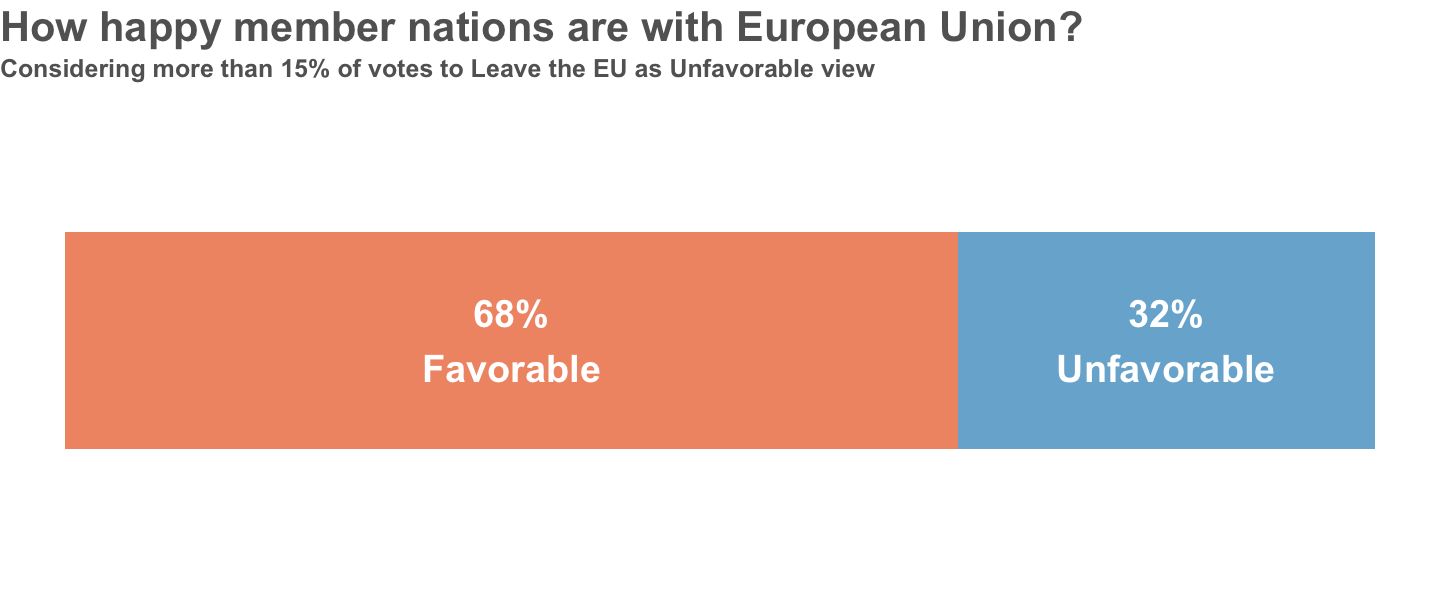

In [23]:
options(repr.plot.width=12, repr.plot.height=5)
happiness_overview

The majority of countries surveyed have shown a favorable view regarding the European Union. However, not everyone is happy with the institution. Across the 22 EU member countries surveyed a median of 32% hold an unfavorable view.

In [24]:
# changing the global plot size back
options(repr.plot.width=15, repr.plot.height=10)

### What countries hold a negative outlook towards the EU?

In [25]:
countries_by_Vote_Leave <- weighted_df_ess %>% group_by(cntry,vteurmmb) %>% 
    summarise(total = survey_total(), prop = survey_mean()) %>%
    filter(vteurmmb == "Leave") %>%
    arrange(desc(prop)) %>%
    head(15)

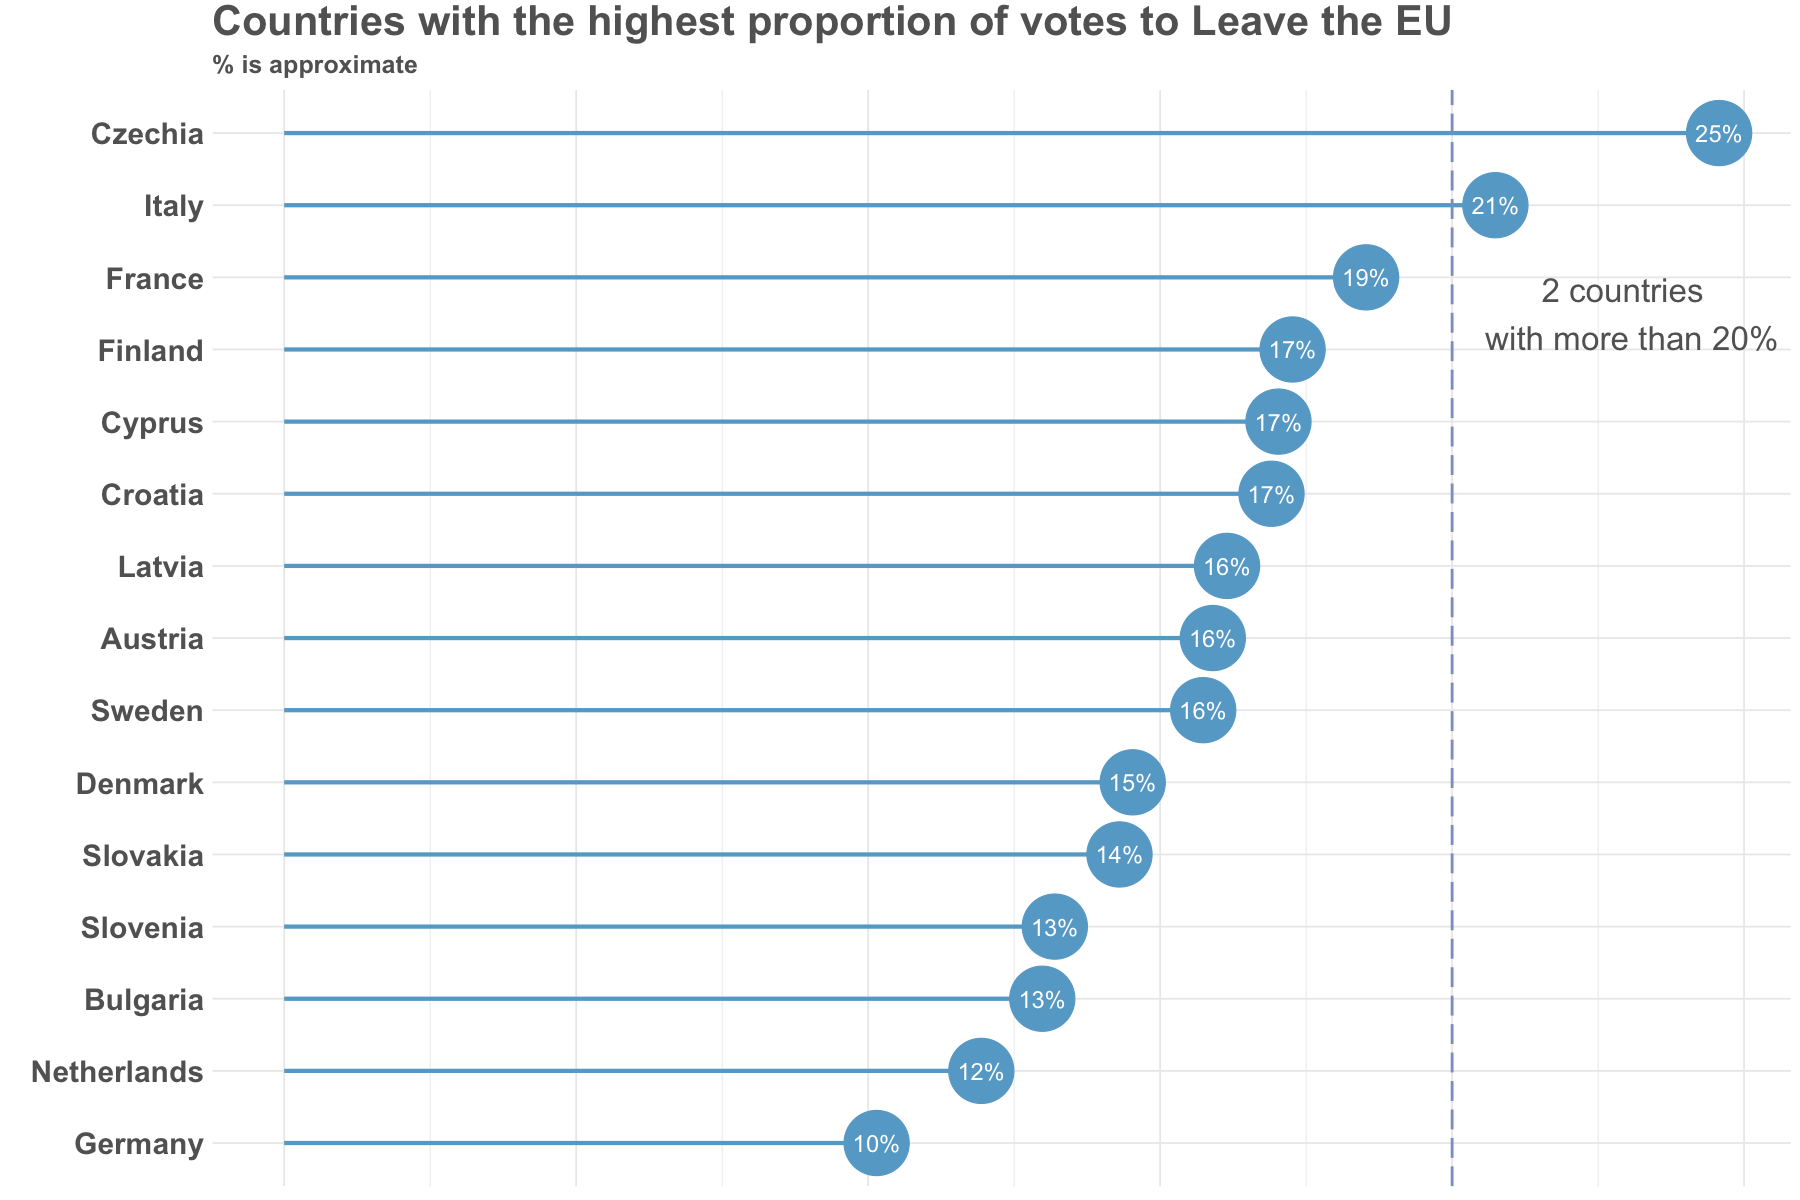

In [26]:
countries_by_Vote_Leave %>% 
mutate(factor(cntry, levels = .$cntry),
      label = paste0(round(prop * 100, 0), "%")) %>%
ggplot(aes(x=reorder(cntry,prop), y=prop)) + 
    geom_segment(aes(xend = cntry, yend = 0), color = "#67a9cf", size=1.2) +
    geom_point(size = 18, color="#67a9cf") +
    geom_text(face="bold", color = "white", size = 5, aes(label = label)) +
    geom_hline(aes(yintercept = .20), colour = "#8da0cb", linetype ="longdash", size = .8) +
    annotate("text", x = 12.5, y = .23, family='', face='bold', colour='#636363', size=7,
               label = "2 countries \n with more than 20%") +
    scale_y_continuous(labels = scales::percent) +
    labs(x = "", y = "",
         title = "Countries with the highest proportion of votes to Leave the EU",
        subtitle = "% is approximate") +
    theme_minimal() + coord_flip() +
    theme(axis.title.x = element_blank(), axis.text.x = element_blank(), axis.ticks.x = element_blank(),
          axis.text.y = element_text(face="bold", color="#636363", size=18),
          plot.title=element_text(vjust=1.5,family='', face='bold', colour='#636363', size=25),
          plot.subtitle=element_text(vjust=1.5,family='', face='bold', colour='#636363', size=15))

The countries with the highest proportion of votes to leave the EU are Czechia, Italy, France, Finland and Cyprus. All of them with **more than 17%** of respondents inclined to vote for their country to **Leave the EU** in a hypothetical referendum. 

__Czechia and Italy__ are the only countries with __more than 20%__ of voting intentions to __Leave the EU__.

### And how about countries that hold strongly positive views of the political union?

In [27]:
countries_by_Vote_Remain <- weighted_df_ess %>% group_by(cntry,vteurmmb) %>% 
    summarise(total = survey_total(), prop = survey_mean()) %>%
    filter(vteurmmb == "Remain") %>%
    arrange(desc(prop)) %>%
    head(15)

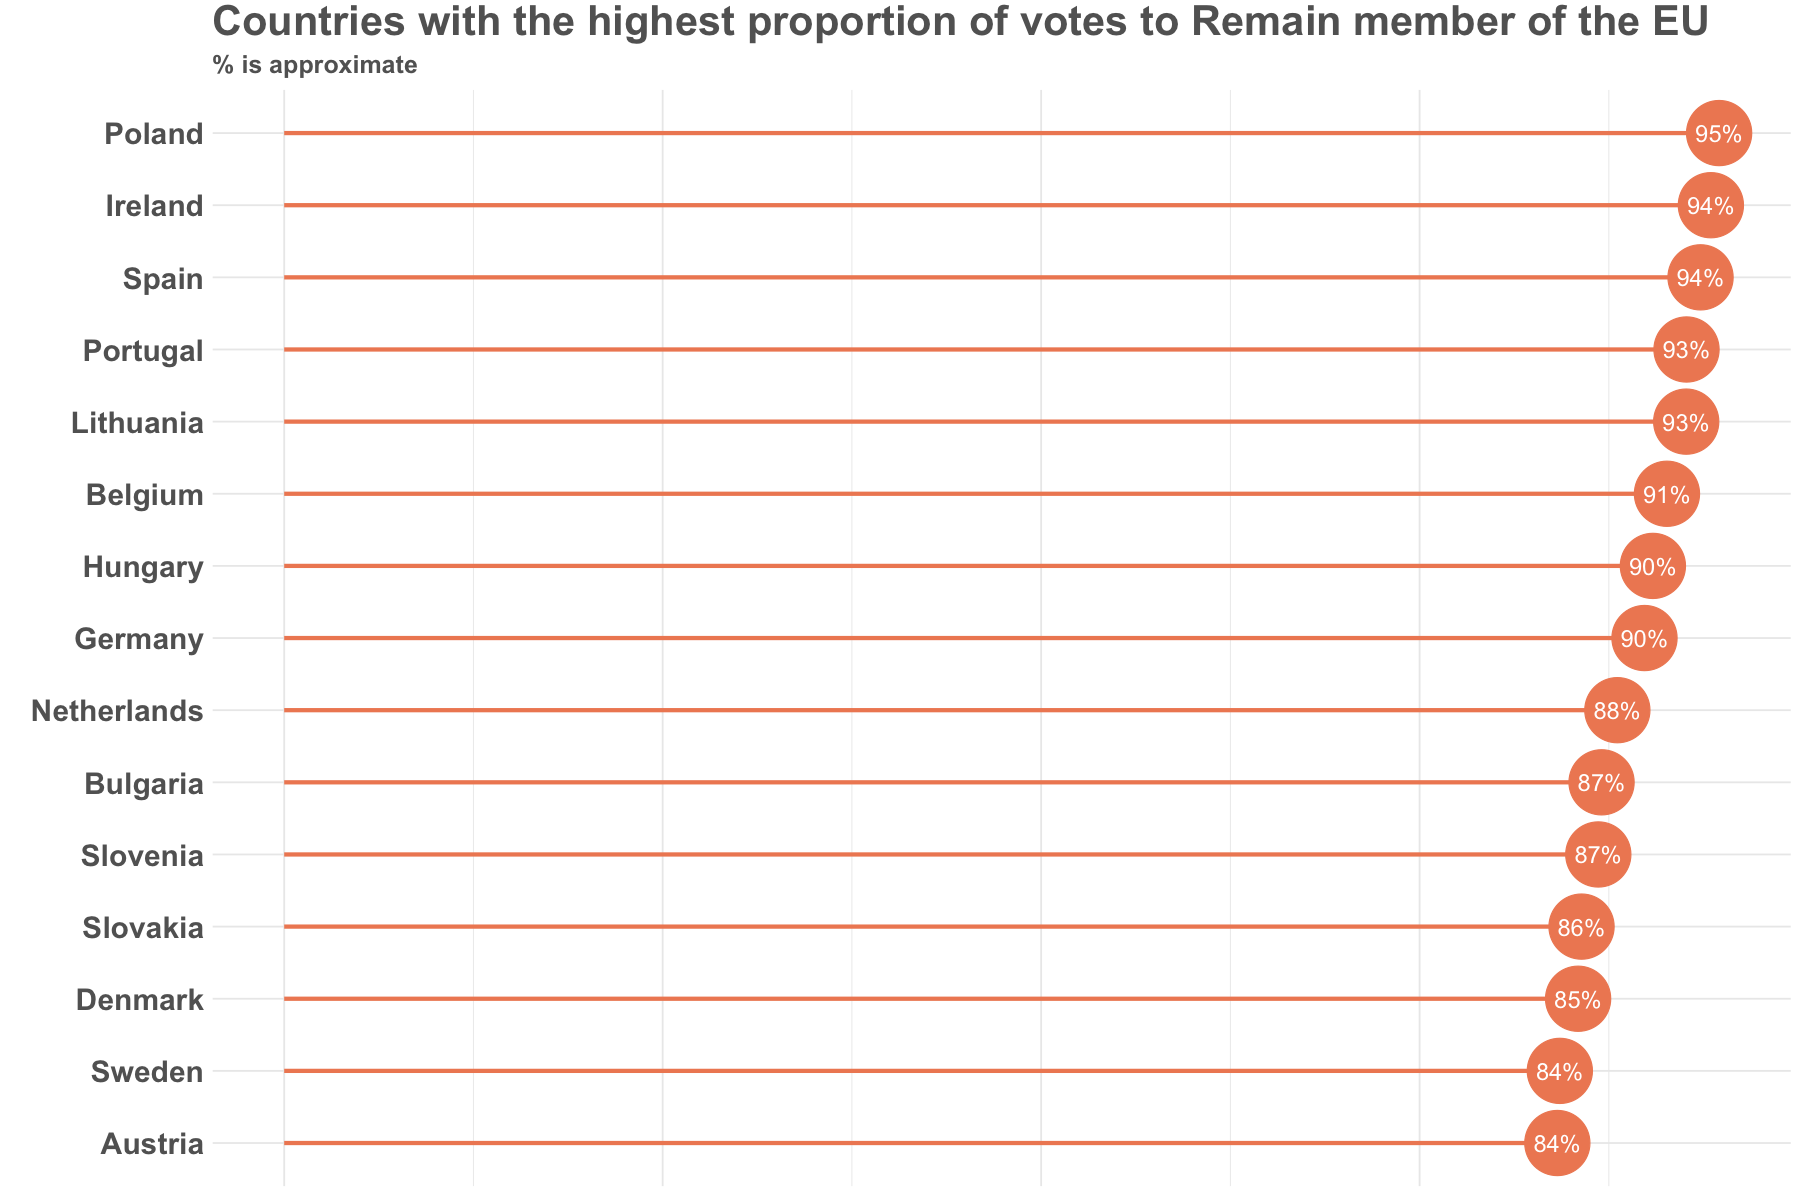

In [28]:
countries_by_Vote_Remain %>% 
mutate(factor(cntry, levels = .$cntry),
      label = paste0(round(prop * 100, 0), "%")) %>%
ggplot(aes(x=reorder(cntry,prop), y=prop)) + 
    geom_segment(aes(xend = cntry, yend = 0), color = "#ef8a62", size=1.2) +
    geom_point(size = 18, color="#ef8a62") +
    geom_text(face="bold", color = "white", size = 5, aes(label = label)) +
    scale_y_continuous(labels = scales::percent) +
    labs(x = "", y = "",
         title = "Countries with the highest proportion of votes to Remain member of the EU",
        subtitle = "% is approximate") +
    theme_minimal() + coord_flip() +
    theme(axis.title.x = element_blank(), axis.text.x = element_blank(), axis.ticks.x = element_blank(),
          axis.text.y = element_text(face="bold", color="#636363", size=18),
          plot.title=element_text(vjust=1.5,family='', face='bold', colour='#636363', size=25),
          plot.subtitle=element_text(vjust=1.5,family='', face='bold', colour='#636363', size=15))

On contrary Poland, Ireland, Spain, Portugal, and Lithuania have more than **92%** of their population voting intentions to **Remain a member of the EU**.

### How is the voting intention when it comes to European regions?

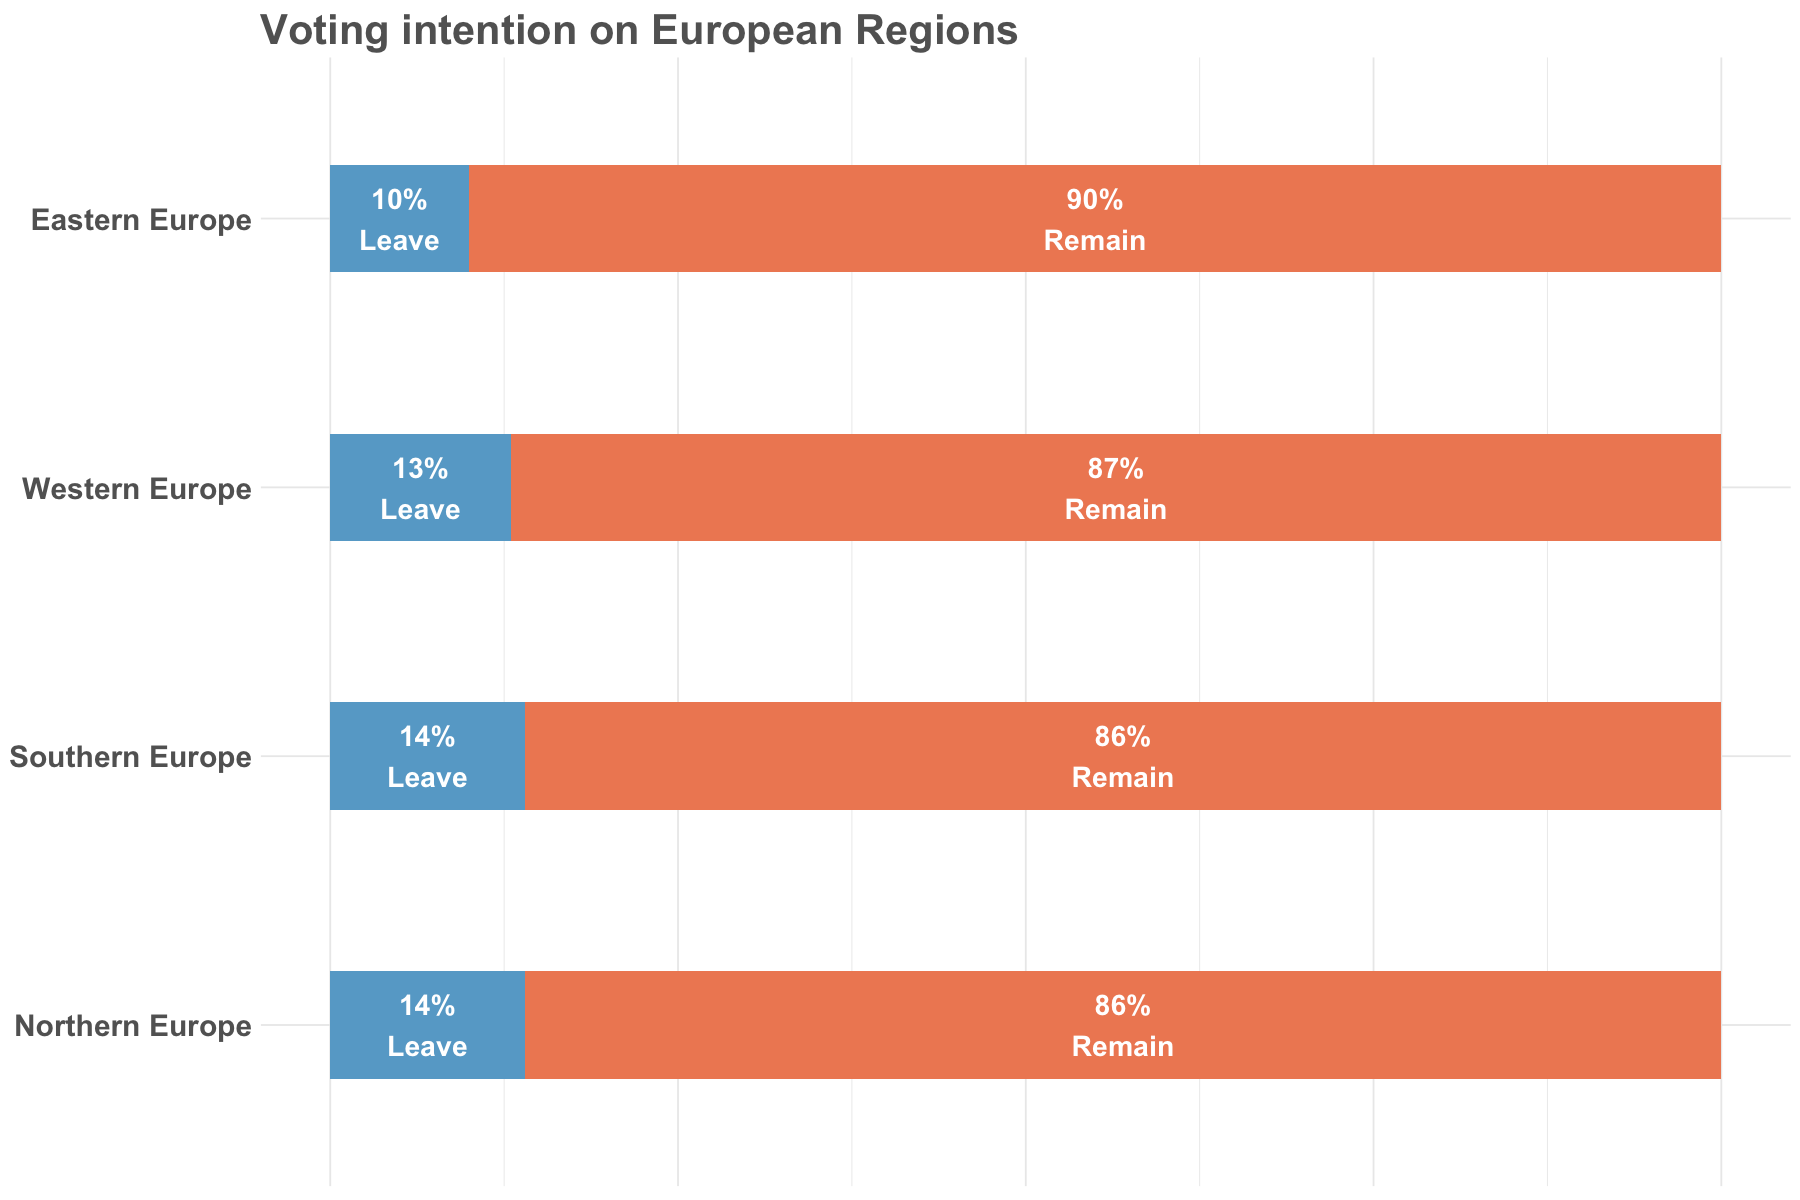

In [29]:
weighted_df_ess %>% 
    group_by(Region,vteurmmb) %>%
    summarise(total = round(survey_total(),2), proportion = round(survey_mean(),2)) %>%
    mutate(label = paste0(round(proportion * 100, 2), "%"), 
           label_y = cumsum(proportion) - 0.5 * proportion) %>%
    ggplot(aes(x= fct_reorder2(Region, vteurmmb, proportion, .desc = FALSE), y=proportion)) + 
    geom_bar(aes(fill=vteurmmb), position = position_stack(reverse = TRUE) ,stat="identity", width = .4) +
    scale_fill_manual(values = c("#67a9cf", "#ef8a62"))  +
    scale_y_continuous(labels = scales::percent) +
    coord_flip() +
    geom_text(aes(y=label_y, label = paste0(label, "\n", vteurmmb)), 
              col = "white",
              size = 6,
              fontface = "bold") +
    labs(x = "", y = "", fill = "",
        title = "Voting intention on European Regions")+ 
    theme_minimal() + 
    theme(legend.position = "none",
          axis.title.x = element_blank(), axis.text.x = element_blank(), axis.ticks.x = element_blank(),
          axis.text.y = element_text(face="bold", color="#636363", size=18),
          axis.title.y = element_blank(),
          plot.title=element_text(vjust=.5,family='', face='bold', colour='#636363', size=25),
          plot.subtitle=element_text(vjust=.5,family='', face='bold', colour='#636363', size=15))

__Northern__ and __Southern__ are the European regions with the __highest EU rejection__ rate, each of them marking 14% voting intentions to Leave the Brussels-based institution. 

Curiously, those regions are also home to 4 countries that have the highest voting intention to Remain. 

Countries with the happiest citizens regarding the EU:

1. Poland
2. __Ireland__
3. __Spain__
4. __Portugal__
5. __Lithuania__

Ireland and Lithuania from the Northern region. Spain and Portugal from the Southern region.

__Eastern__ is the region that holds the most __favorable views__ of European Union. But not all countries in the Eastern region are happy, __Czechia__ is a country there that presented the highest voting __intention to Leave__ the EU.

<a id='4.2'></a>
## Gender-Age Overview

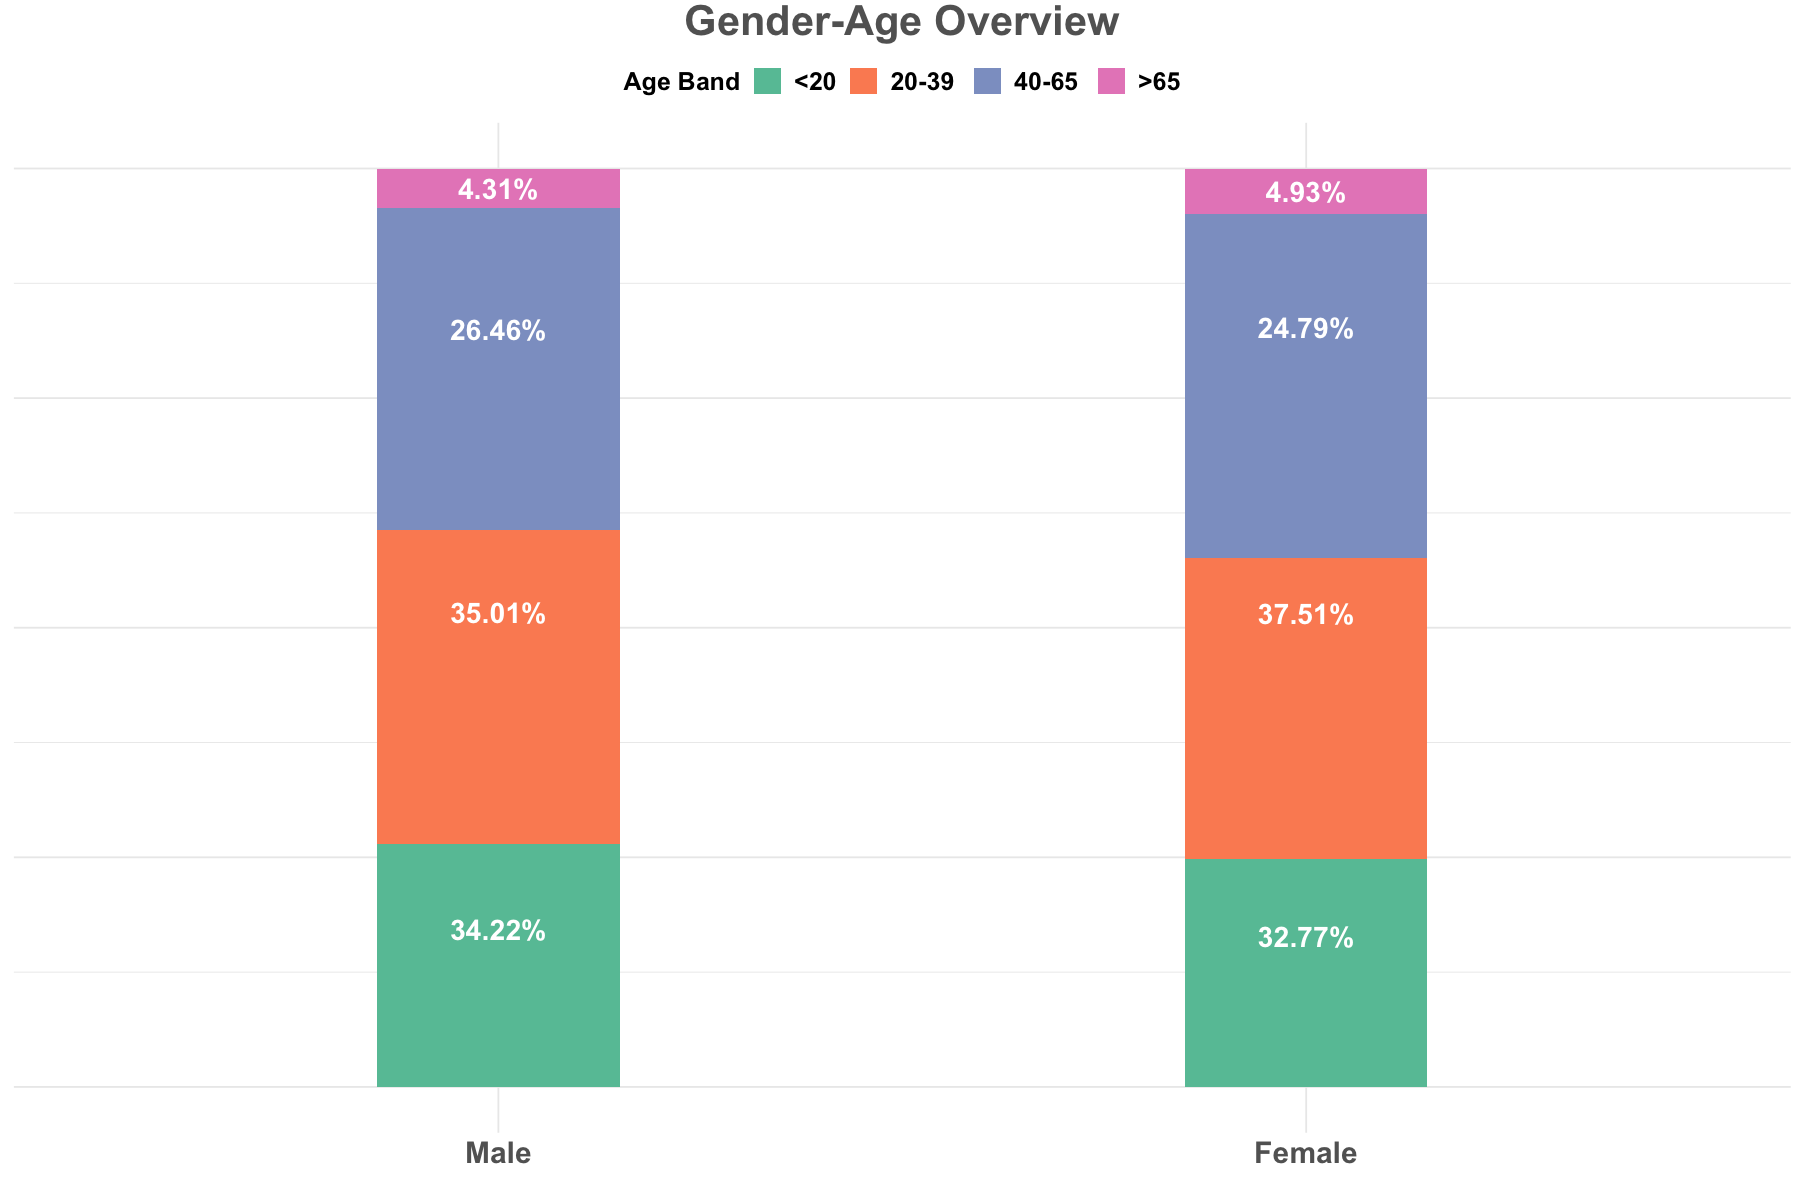

In [30]:
weighted_df_ess %>%
    group_by(gndr,Age_Band) %>%
    summarise(total = round(survey_total(),2), proportion = survey_mean()) %>%
    mutate(label = paste0(round(proportion * 100, 2), "%"), 
       label_y = cumsum(proportion) - 0.5 * proportion) %>%
    ggplot(aes(x= gndr, y=proportion)) + 
    geom_bar(aes(fill=factor(Age_Band,levels=c("<20","20-39","40-65",">65"))),
             stat="identity",
             position = position_stack(reverse = TRUE),
             width = .3) +
    scale_y_continuous(labels = scales::percent) +
    scale_fill_brewer(palette='Set2') +
    geom_text(aes(y=label_y, label = label), 
              col = "white",
              size = 6,
              fontface = "bold") +
    labs(x = "", y = "", fill = "Age Band", title = "Gender-Age Overview") +
    theme_minimal() + 
    theme(legend.position = "top", 
          legend.direction = "horizontal",legend.title = element_text(size=15, face="bold"),
          legend.text = element_text(size=15, face="bold"),
          axis.text.x = element_text(face="bold", color="#636363", size=18),
          axis.title.y = element_blank(), axis.text.y = element_blank(), axis.ticks.y = element_blank(),
          plot.title=element_text(hjust = 0.5,vjust=1.5,family='', face='bold', colour='#636363', size=25))

<a id='4.3'></a>
## Age Overview by Voting Intention

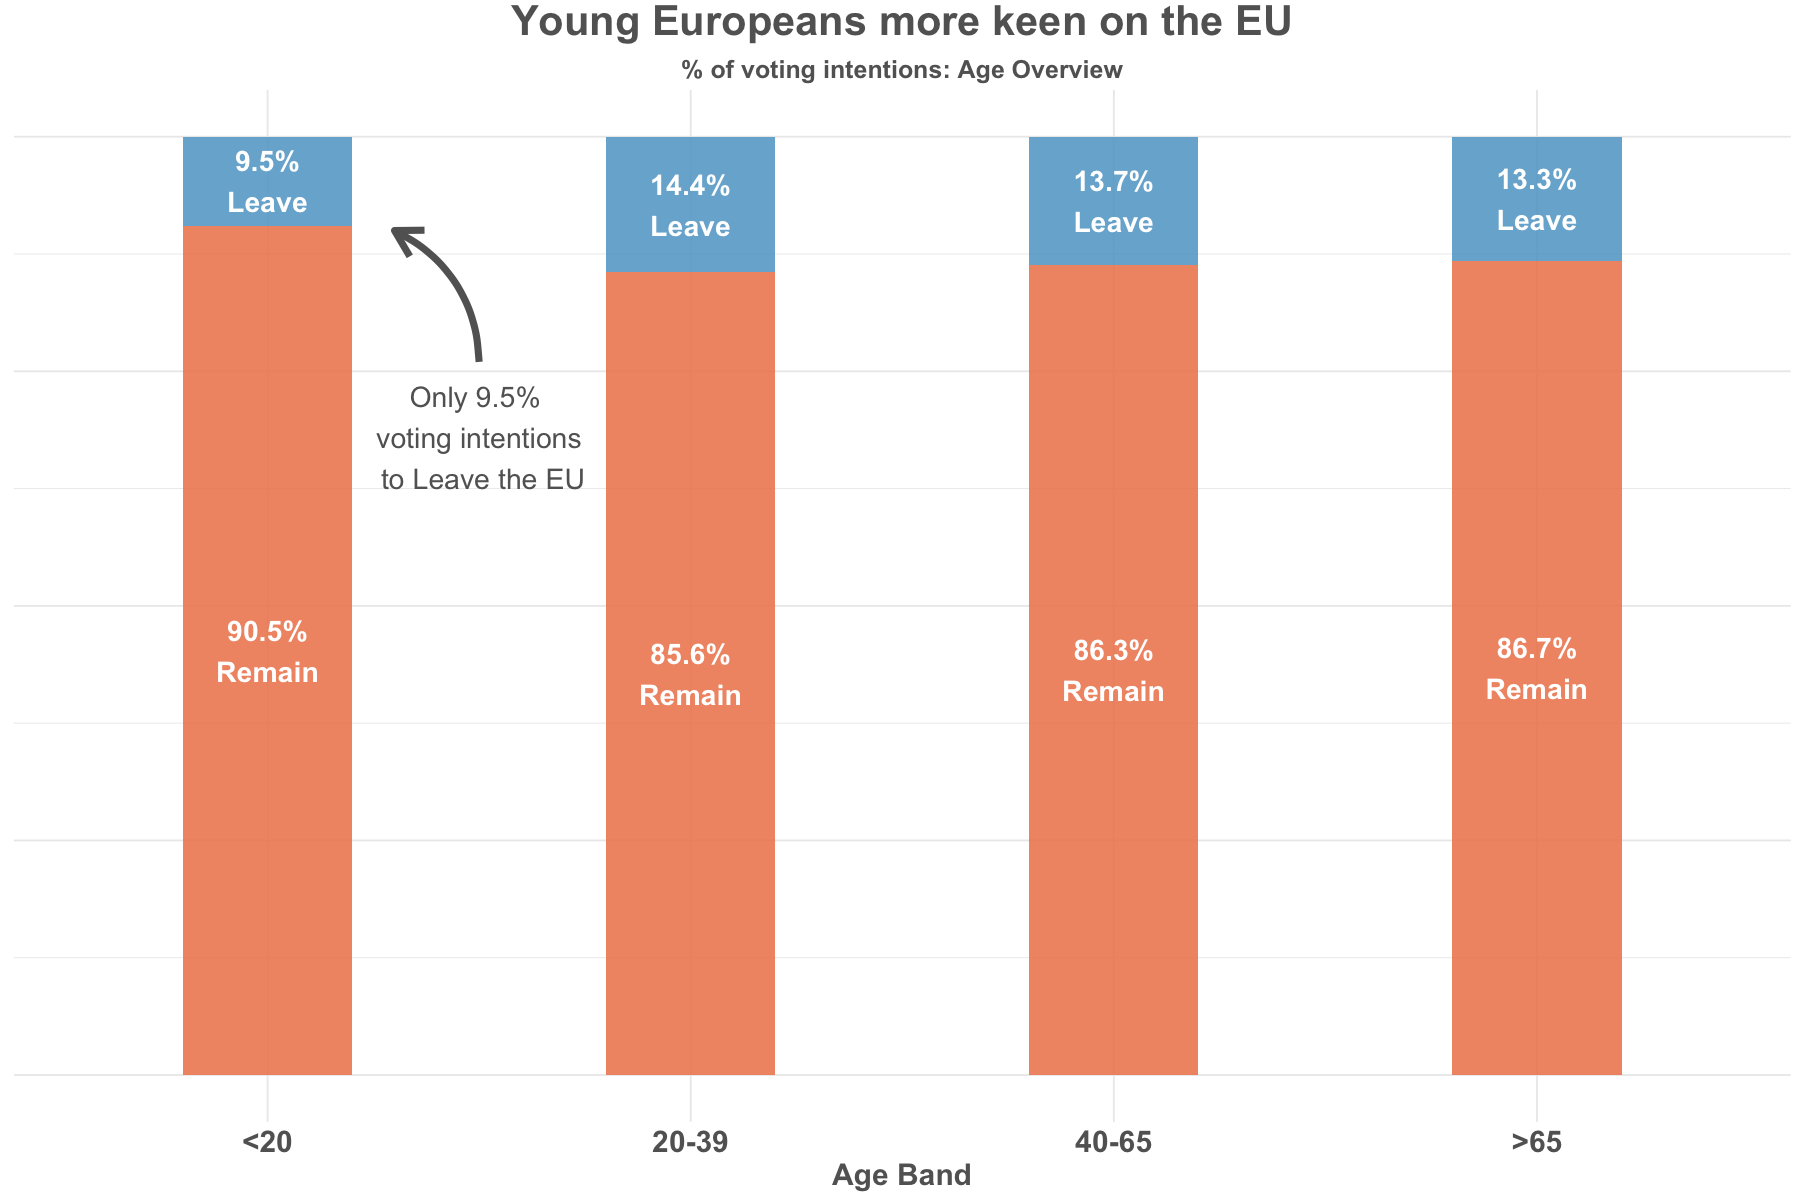

In [31]:
weighted_df_ess %>%
    group_by(Age_Band,vteurmmb) %>%
    summarise(total = round(survey_total(),2), proportion = survey_mean()) %>%
    mutate(label = paste0(round(proportion * 100, 1), "%"), 
           label_y = cumsum(proportion) - 0.5 * proportion) %>%
    ggplot(aes(x= factor(Age_Band,levels=c("<20","20-39","40-65",">65")), y=proportion, 
               fill=factor(vteurmmb,levels=c("Leave","Remain")))) + 
    geom_bar(stat="identity", width = .4, alpha= .9) +
    scale_fill_manual(values = c("Remain" = "#ef8a62", "Leave" = "#67a9cf")) +
    geom_text(aes(label = paste0(label, "\n", vteurmmb)),position = position_stack(vjust = 0.5), 
              col = "white", size = 6, fontface = "bold") +
    annotate("curve", curvature = .3, x = 1.5, xend = 1.3, y = .76, yend = .90,
               colour = "#636363", size = 2, arrow = arrow()) +
    annotate("text", x = 1.5, y = .68, family='', face='bold', colour='#636363', size=6,
               label = "Only 9.5% \n voting intentions \n to Leave the EU") +
    scale_y_continuous(labels = scales::percent) +
    labs(x = "Age Band", y = "", fill = "Age Band", 
         title = "Young Europeans more keen on the EU",
        subtitle = "% of voting intentions: Age Overview") +
    theme_minimal()  +
    theme(legend.position = "none",
          axis.text.x = element_text(face="bold", color="#636363", size=18),
          axis.title.x = element_text(face="bold", color="#636363", size=18),
          axis.title.y = element_blank(), axis.text.y = element_blank(), axis.ticks.y = element_blank(),
          plot.title=element_text(hjust = 0.5,vjust=1.5,family='', face='bold', colour='#636363', size=25),
          plot.subtitle=element_text(hjust = 0.5,vjust=.5,family='', face='bold', colour='#636363', size=15))

__Younger people__ (ages 20 and younger) have more favorable views (__90.5%__) than __older__ counterparts (around __86%__), for example, (ages 40 to 65 / ages 65 and older) when it comes to the EU. What we call __Young Adults__ (ages 20 to 39) manifested the highest intentions (around __14.5%__) of Leaving the EU.

<a id='4.4'></a>
## Education Overview

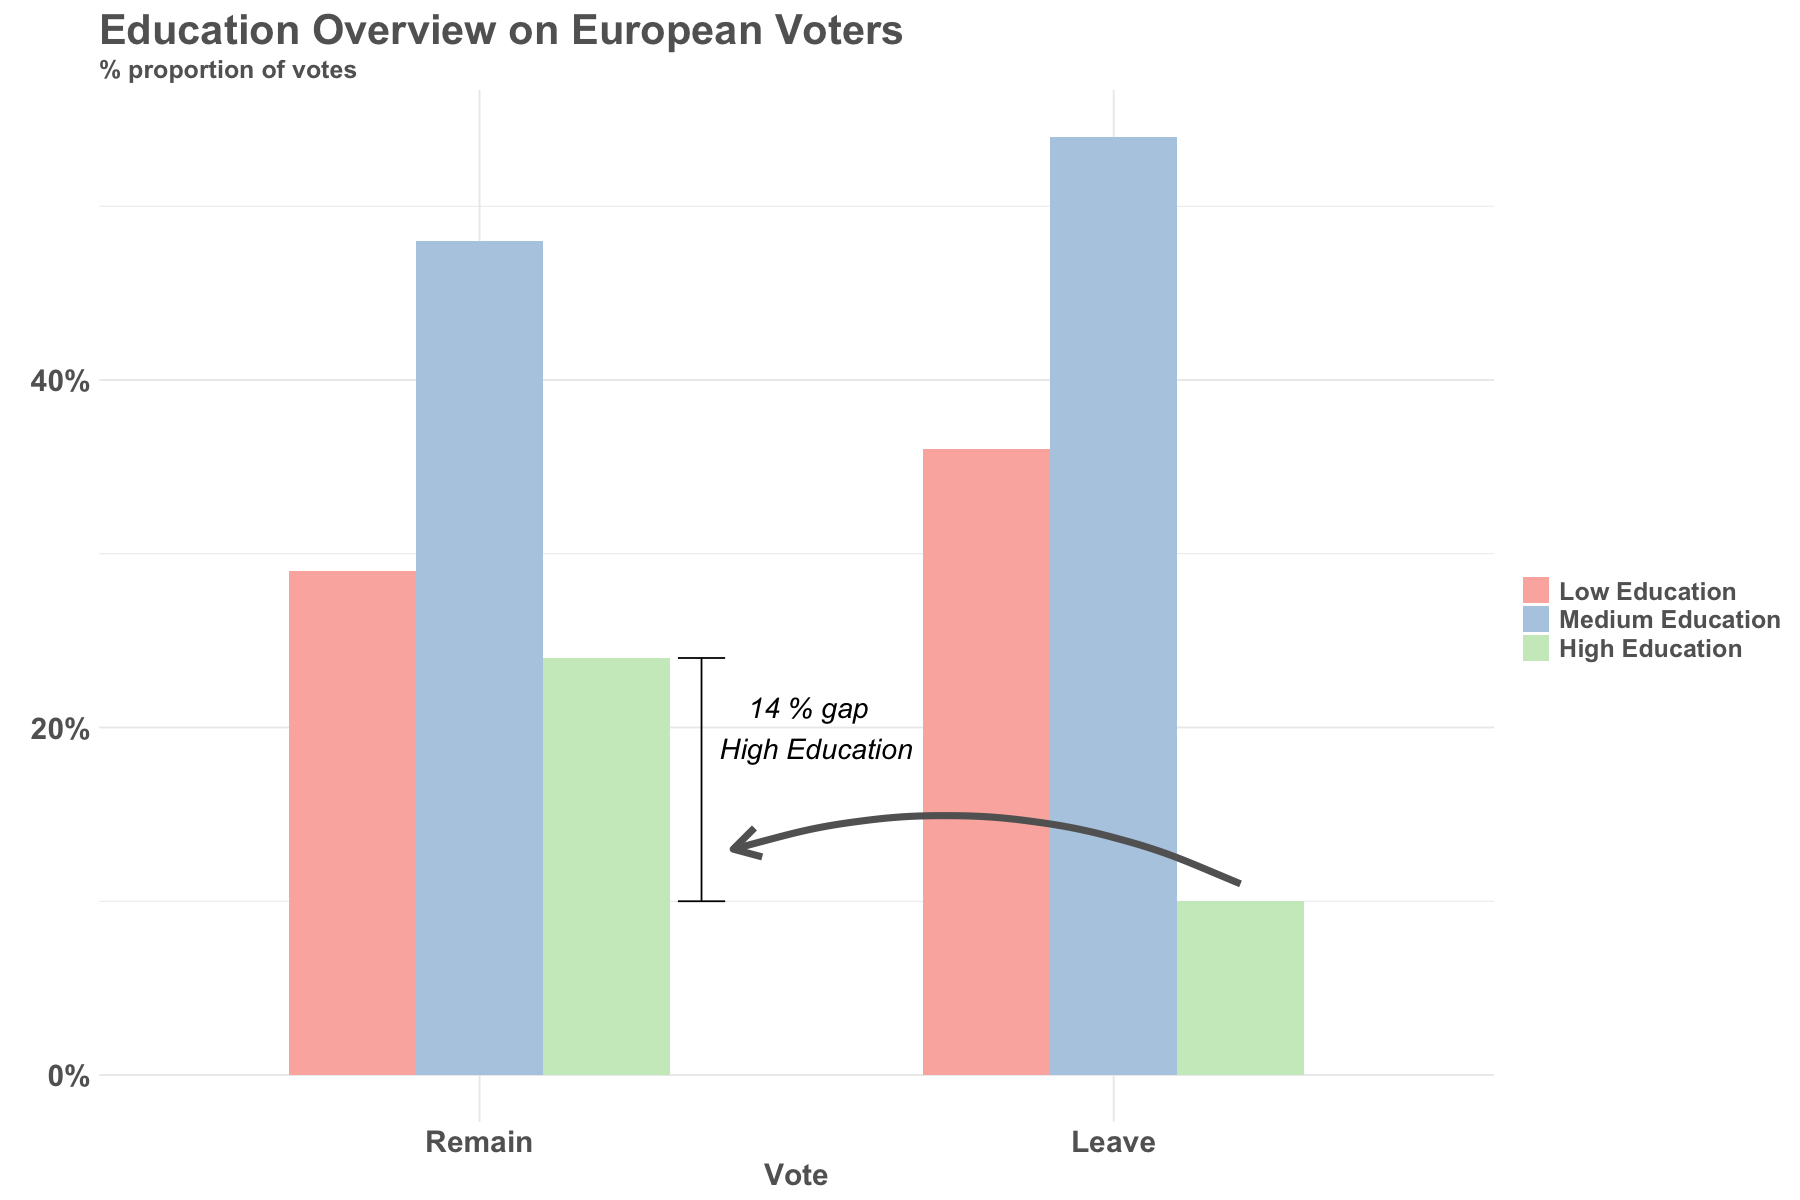

In [32]:
weighted_df_ess %>% 
    group_by(vteurmmb,Education) %>%
    summarise(total = round(survey_total(),2), proportion = round(survey_mean(),2)) %>%
    ggplot(aes(x= factor(vteurmmb,levels=c("Remain","Leave")), y=proportion, 
               fill=factor(Education,levels=c("Low Education","Medium Education","High Education")))) + 
    geom_bar(position="dodge",stat="identity", width = .6) +
    scale_fill_brewer(palette = "Pastel1") +
    scale_y_continuous(labels = scales::percent) +
    annotate("segment", x = 1.35, xend = 1.35, y = .10, yend = .24,
               arrow = arrow(ends = "both", angle = 90, length = unit(.5,"cm"))) +
    annotate("curve", curvature = .2, x = 2.2, xend =1.4, y = .11, yend = .13,
               colour = "#636363", size = 2, arrow = arrow()) +
    annotate("text", x = 1.525, y = .20, family = "", fontface = 3, size=6,
               label = "14 % gap \n High Education") +
    labs(x = "Vote", y = "",fill = "", 
         title = "Education Overview on European Voters",
         subtitle = "% proportion of votes") + 
    theme_minimal() + 
    theme(legend.text = element_text(size=15, face="bold",colour='#636363'),
          axis.text.x = element_text(face="bold", color="#636363", size=18),
          axis.title.x = element_text(face="bold", color="#636363", size=18),
          axis.text.y = element_text(face="bold", color="#636363", size=18),
          plot.title=element_text(vjust=.5,family='', face='bold', colour='#636363', size=25),
          plot.subtitle=element_text(vjust=.5,family='', face='bold', colour='#636363', size=15))

Among all levels of Education in European voters, the biggest __disparity__ is on __High Education__ which can be noted as a __14 percentage point gap__. Those with more education have more positive opinions of the EU.

When it comes to citizens with voting intentions to __Leave the EU__, those with a __Medium Education level__ represent __more than 50%__ and __Low and Medium Education__ levels are the vast majority representing __90%__ of those voters.

In [33]:
# Filtering the countries to use later on data viz
target_countries_l <- countries_by_Vote_Leave %>% arrange(desc(prop)) %>% head(5) %>% select(cntry)
target_countries_l$index <- seq.int(nrow(target_countries_l)) # adding an ordered index
target_countries_r <- countries_by_Vote_Remain %>% arrange(desc(prop)) %>% head(5) %>% select(cntry)
target_countries_r$index <- seq.int(nrow(target_countries_r))

In [34]:
countries_education_leave <- weighted_df_ess %>% 
    group_by(cntry,Education) %>%
    summarise(total = round(survey_total(),2), proportion = round(survey_mean(),2)) %>%
    filter(cntry %in% target_countries_l$cntry) %>% 
    arrange(desc(cntry,Education,proportion)) %>%
    ggplot(aes(x= factor(cntry, labels=target_countries_l$cntry), y=proportion)) + 
    geom_bar(aes(fill=factor(Education,levels=c("Low Education","Medium Education","High Education"))),
             position="dodge",stat="identity", width = .6) +
    geom_hline(aes(yintercept = 0.20), colour = "#8da0cb", linetype ="longdash", size = .8) +
    scale_fill_brewer(palette = "Pastel1") +
    scale_y_continuous(labels = scales::percent) +
    labs(x = "",
        y = "",
        fill = "Education",
        title = "Countries with highest proportion of votes to Leave the EU",
        subtitle = "Educational overview") + 
    theme_minimal() + 
    theme(legend.text = element_text(size=12, face="bold", color="#636363"),
          axis.text.x = element_text(face="bold", color="#636363", size=12),
          legend.title = element_blank(), 
          plot.title=element_text(vjust=.5,family='', face='bold', colour='#636363', size=15),
          plot.subtitle=element_text(vjust=.5,family='', face='bold', colour='#636363', size=12))

In [35]:
countries_education_remain <- weighted_df_ess %>% 
    group_by(cntry,Education) %>%
    summarise(total = round(survey_total(),2), proportion = round(survey_mean(),2)) %>%
    filter(cntry %in% target_countries_r$cntry) %>% 
    arrange(desc(cntry,Education,proportion)) %>%
    ggplot(aes(x= factor(cntry, labels=target_countries_r$cntry), y=proportion)) + 
    geom_bar(aes(fill=factor(Education,levels=c("Low Education","Medium Education","High Education"))),
             position="dodge",stat="identity", width = .6) +
    geom_hline(aes(yintercept = 0.20), colour = "#8da0cb", linetype ="longdash", size = .8) +
    scale_fill_brewer(palette = "Pastel1") +
    scale_y_continuous(labels = scales::percent) +
    labs(x = "",
        y = "",
        fill = "Education",
        title = "Countries with highest proportion of votes to Remain member of EU",
        subtitle = "Educational overview") + 
    theme_minimal() +
    theme(axis.text.x = element_text(face="bold", color="#636363", size=12),legend.position = "none", 
          plot.title=element_text(vjust=.5, face='bold', colour='#636363', size=15),
          plot.subtitle=element_text(vjust=.5,family='', face='bold', colour='#636363', size=12))

### Comparison between countries with opposing views of EU: an Educational perspective

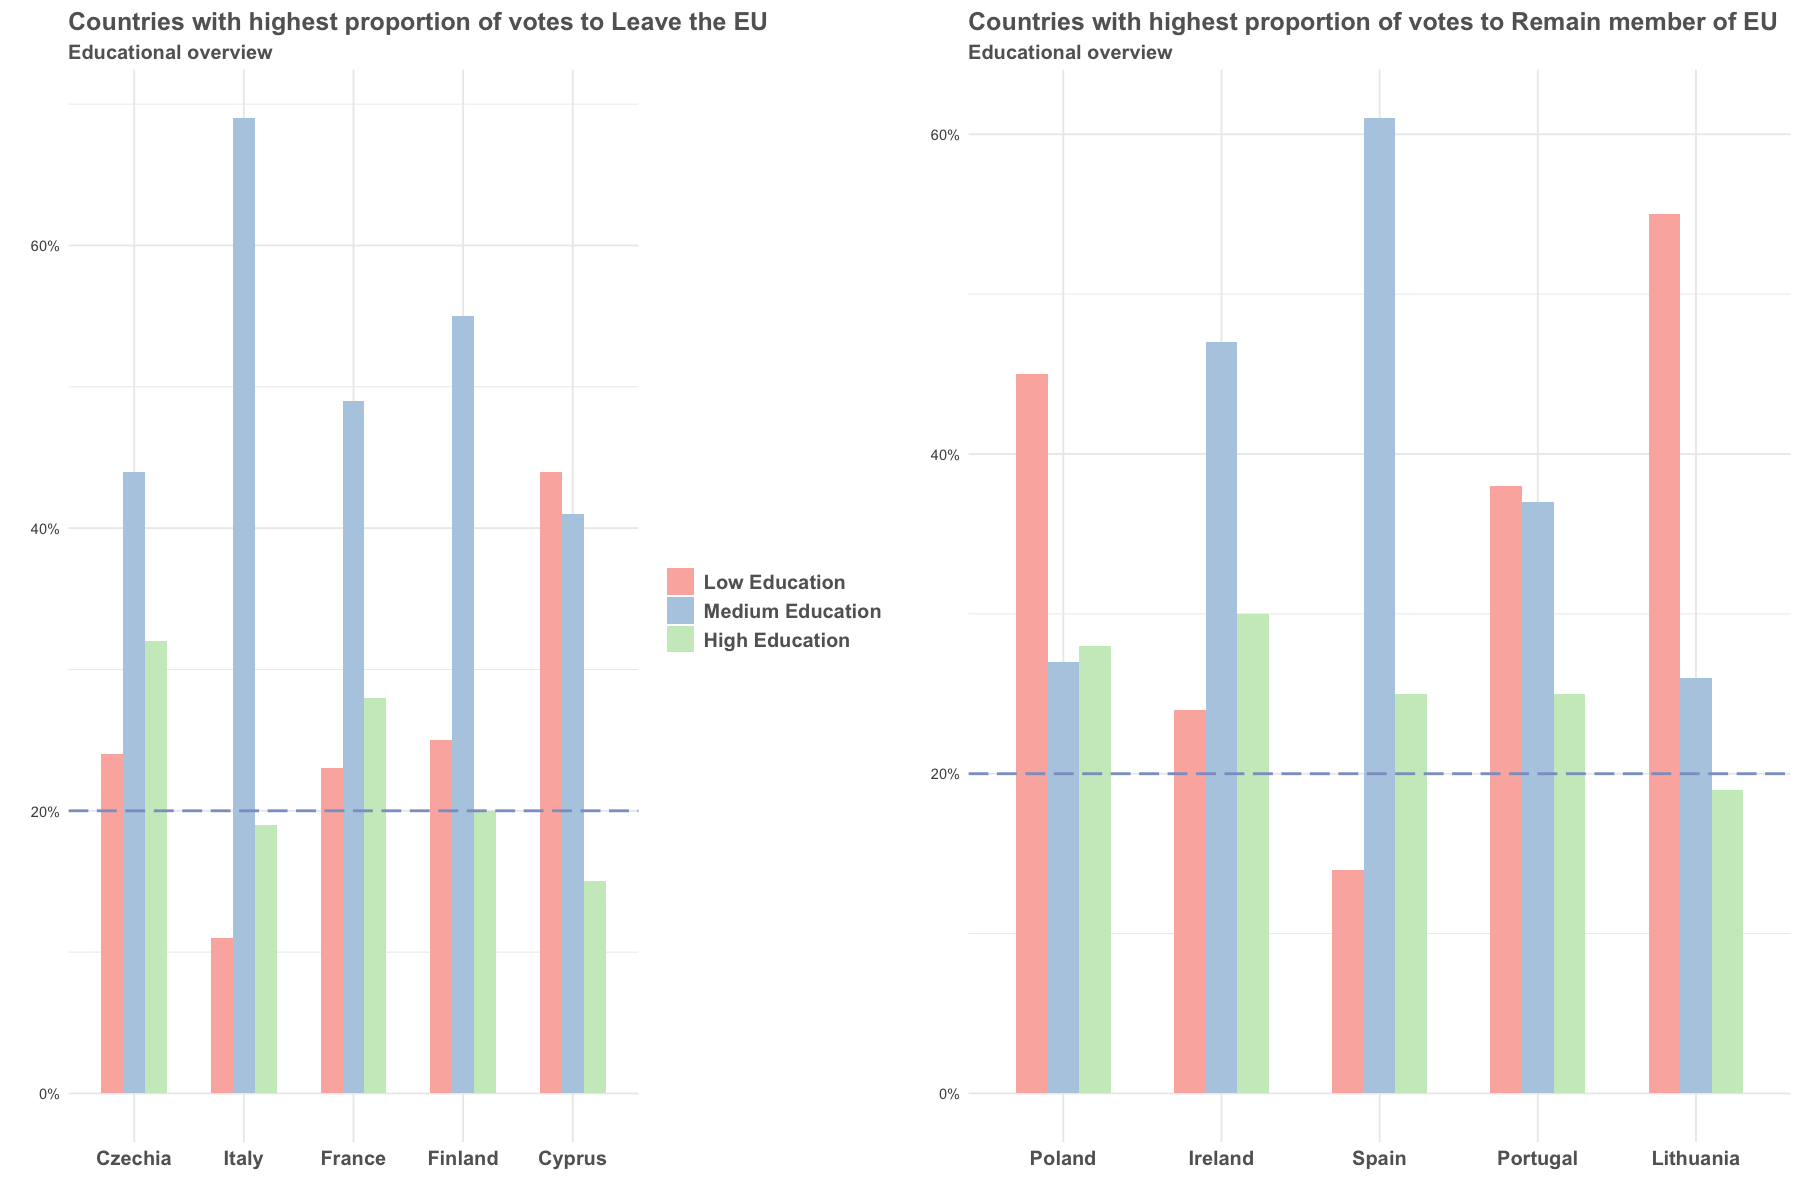

In [36]:
ggarrange(countries_education_leave, countries_education_remain, ncol = 2, nrow = 1)

In countries that hold a negative outlook towards the EU, only 2 (__Czechia and France__) have __more than 20%__ of their population with a __High level of Education__. Italy and Finland presented more than half of respondents claiming Medium Education as the highest level. 

On those countries that see the EU in a positive light, only __Lithuania__ has shown a __High Education Level below 20%__.

<a id='4.5'></a>
## Unemployment rate

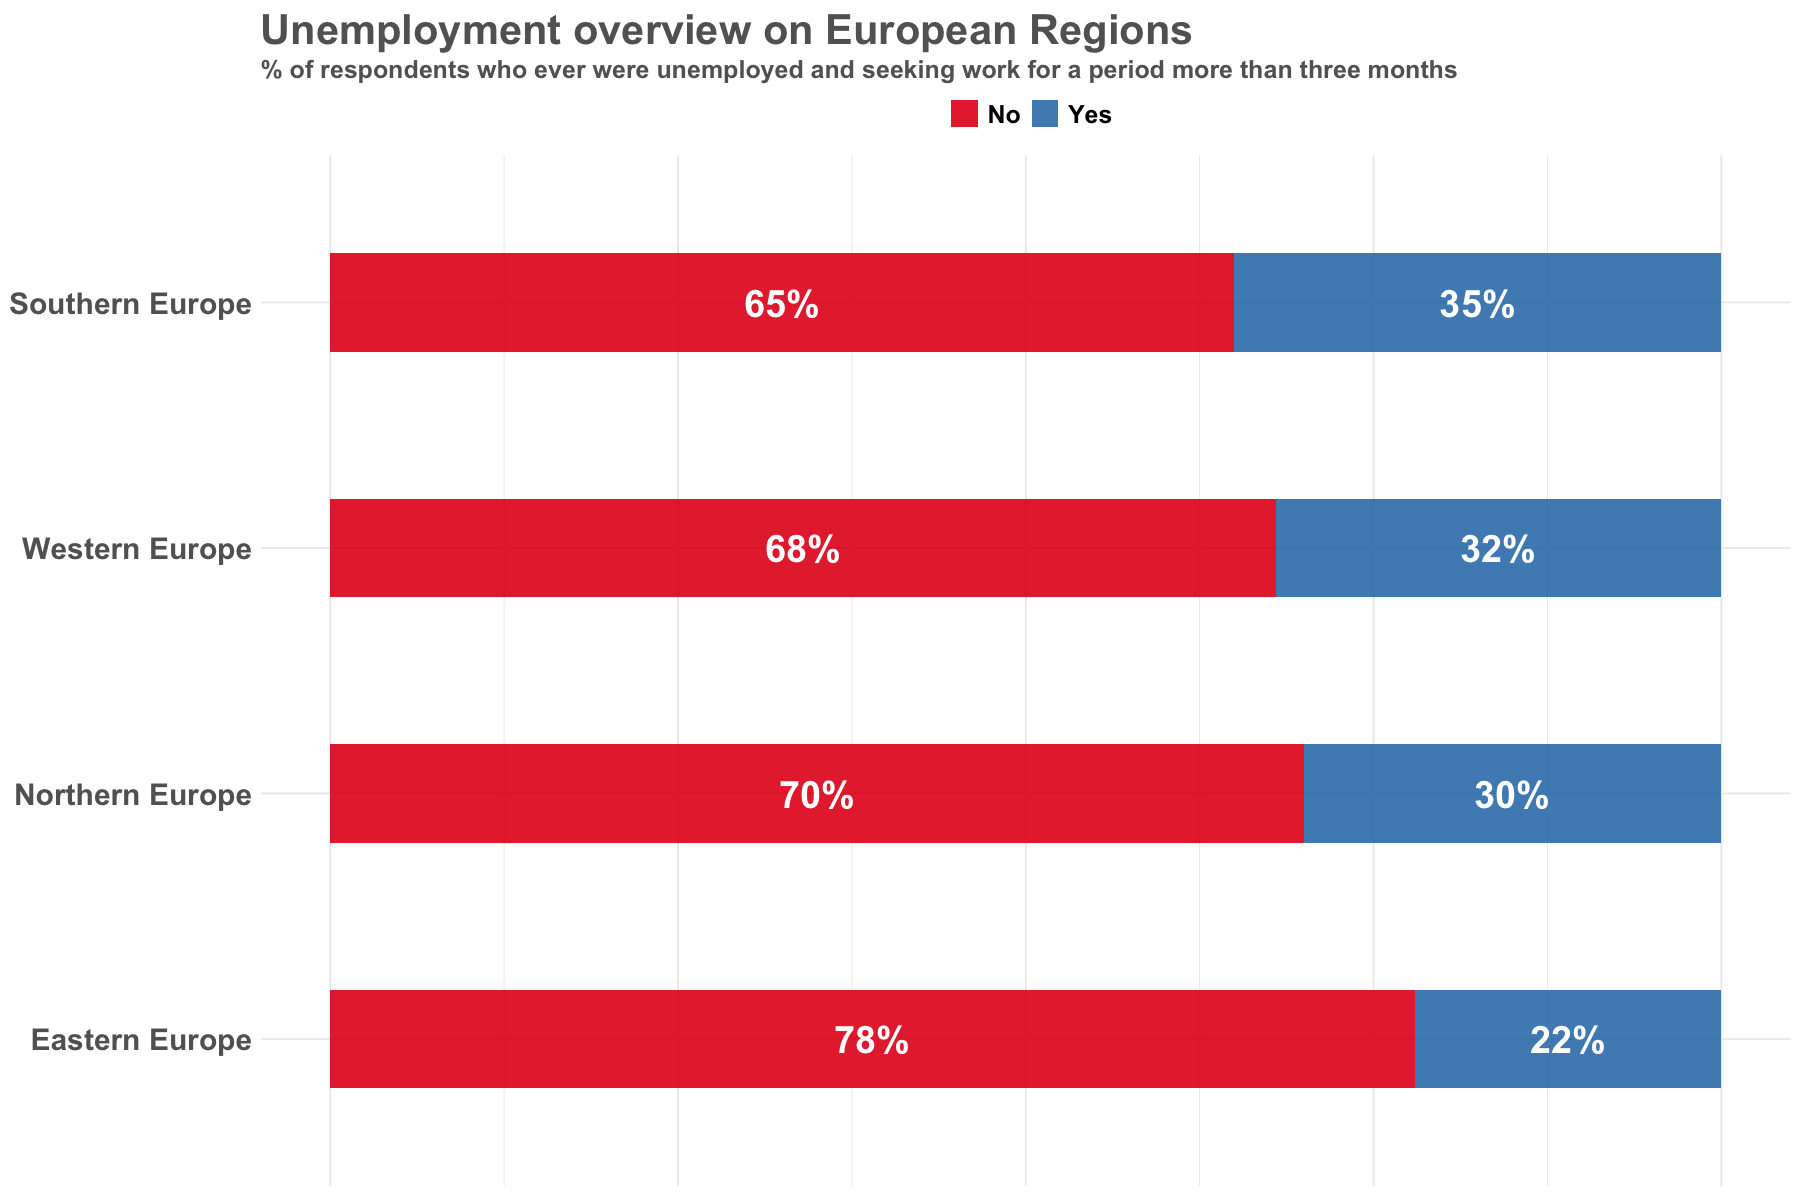

In [37]:
weighted_df_ess %>% 
    group_by(Region,uemp3m) %>%
    summarise(total = round(survey_total(),2), proportion = round(survey_mean(),2)) %>%
    mutate(label = paste0(round(proportion * 100, 2), "%"), 
           label_y = cumsum(proportion) - 0.5 * proportion) %>%
    ggplot(aes(x= fct_reorder2(Region, uemp3m, proportion, .desc = FALSE), y=proportion)) + 
    geom_bar(aes(fill=uemp3m), position = position_stack(reverse = TRUE) ,stat="identity", width = .4, alpha = .9) +
    scale_fill_brewer(palette='Set1') +
    scale_y_continuous(labels = scales::percent) +
    coord_flip() +
    geom_text(aes(y=label_y, label = label), 
              col = "white",
              size = 8,
              fontface = "bold") +
    labs(x = "", y = "", fill = "",
        title = "Unemployment overview on European Regions",
        subtitle = "% of respondents who ever were unemployed and seeking work for a period more than three months")+ 
    theme_minimal() + 
    theme(legend.position = "top", 
          legend.direction = "horizontal",
          legend.text = element_text(size=15, face="bold"),
          axis.title.x = element_blank(), axis.text.x = element_blank(), axis.ticks.x = element_blank(),
          axis.text.y = element_text(face="bold", color="#636363", size=18),
          axis.title.y = element_blank(),
          plot.title=element_text(vjust=.5,family='', face='bold', colour='#636363', size=25),
          plot.subtitle=element_text(vjust=.5,family='', face='bold', colour='#636363', size=15))

Several EU countries have become more positive about joining the EU over the past few years after some fluctuation amid economic uncertainty. 

Portugal, Spain, Italy and Cyprus were countries from the Southern Region that felt the full effects of the [European sovereign debt crisis](https://edition.cnn.com/2013/07/27/world/europe/european-debt-crisis-fast-facts/index.html). In these countries, the effects of the crisis reflects on the high unemployment rate reported.

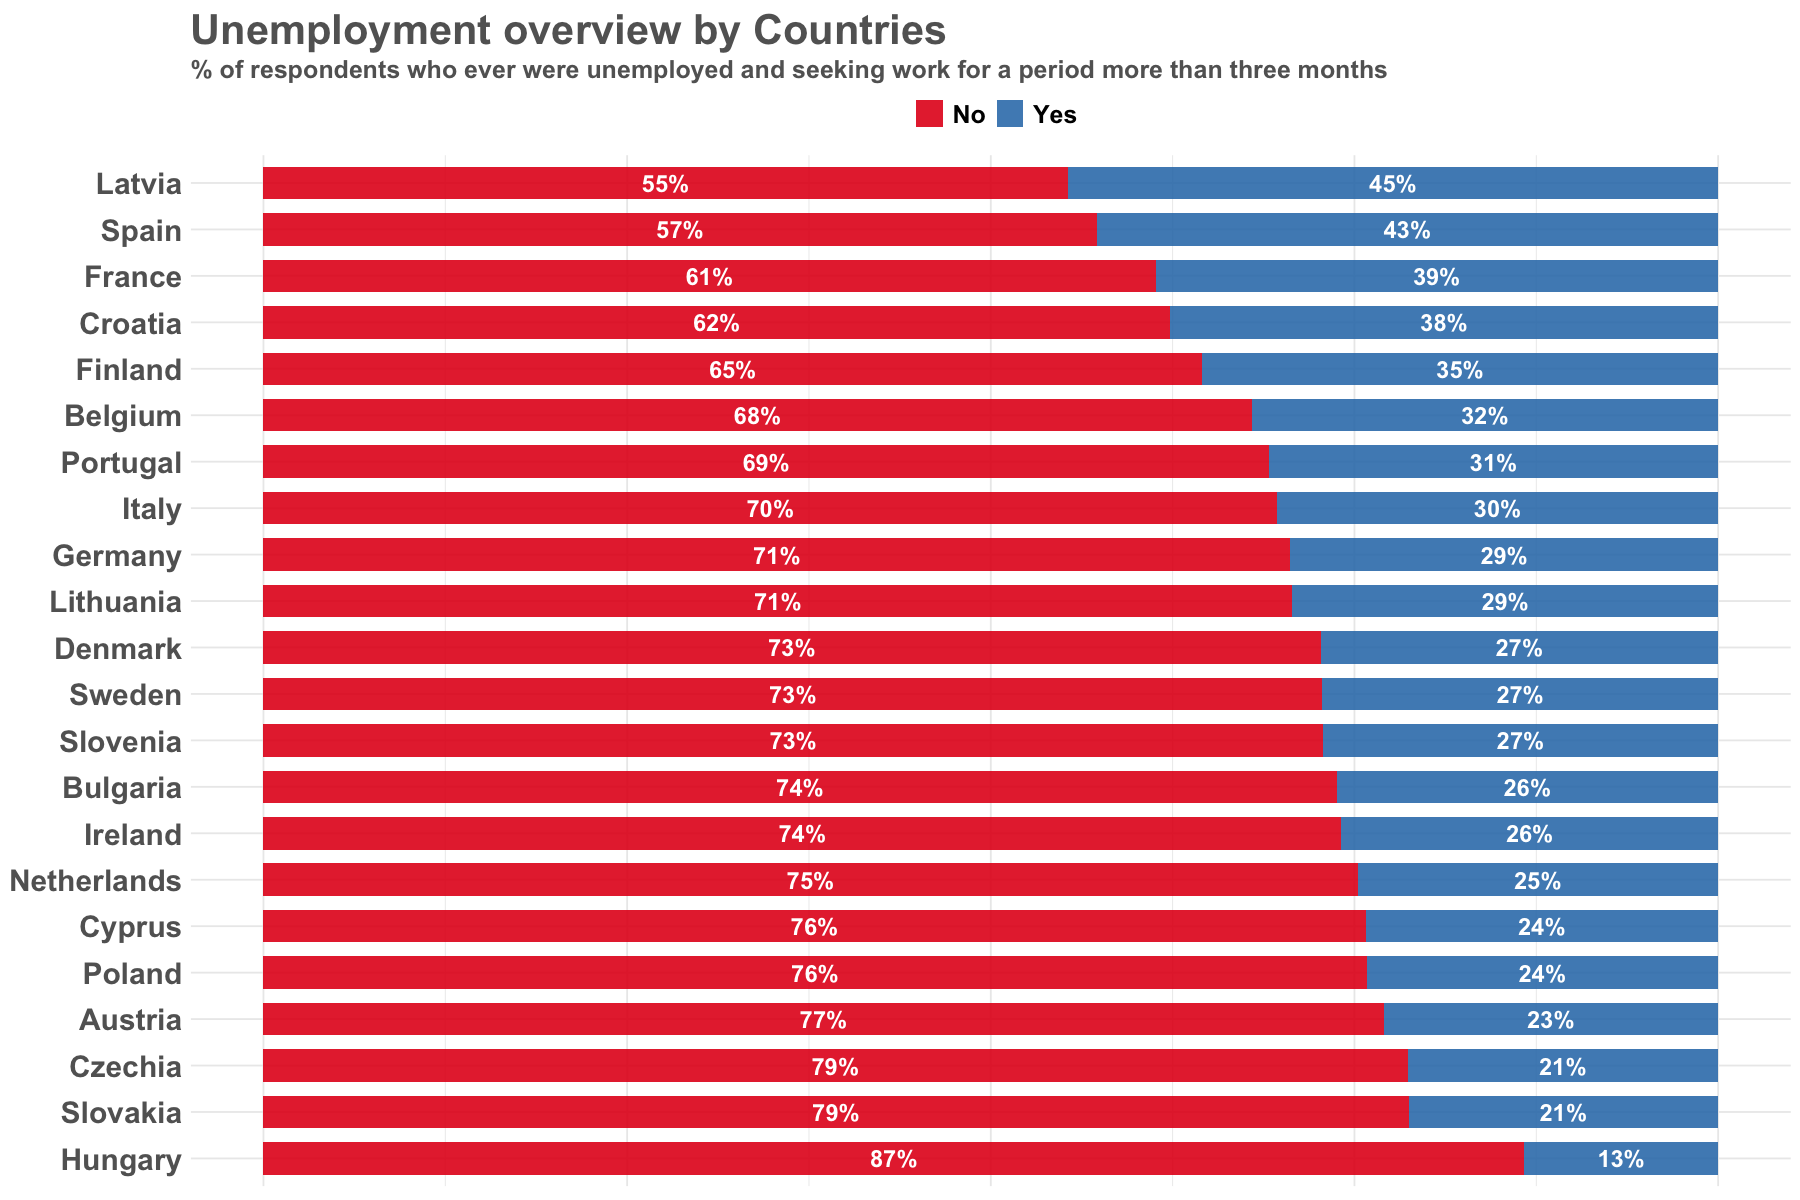

In [38]:
weighted_df_ess %>% 
    group_by(cntry,uemp3m) %>%
    summarise(total = round(survey_total(),2), proportion = survey_mean()) %>%
    mutate(label = paste0(round(proportion * 100, 0), "%"), 
           label_y = cumsum(proportion) - 0.5 * proportion) %>%
    ggplot(aes(x= fct_reorder2(cntry, uemp3m, proportion, .desc = FALSE), y=proportion)) + 
    geom_bar(aes(fill=uemp3m), position = position_stack(reverse = TRUE) ,stat="identity", width = .7, alpha= .9) +
    scale_fill_brewer(palette='Set1') +
    scale_y_continuous(labels = scales::percent) +
    coord_flip() +
    geom_text(aes(y=label_y, label = label), 
              col = "white",
              size = 5,
              fontface = "bold") +
    labs(x = "", y = "", fill = "",
        title = "Unemployment overview by Countries",
        subtitle = "% of respondents who ever were unemployed and seeking work for a period more than three months")+ 
    theme_minimal() + 
    theme(legend.position = "top", 
          legend.direction = "horizontal",
          legend.text = element_text(size=15, face="bold"),
          axis.title.x = element_blank(), axis.text.x = element_blank(), axis.ticks.x = element_blank(),
          axis.text.y = element_text(face="bold", color="#636363", size=18),
          axis.title.y = element_blank(),
          plot.title=element_text(vjust=.5,family='', face='bold', colour='#636363', size=25),
          plot.subtitle=element_text(vjust=.5,family='', face='bold', colour='#636363', size=15))

__Latvia and Spain__ are the only EU Countries with an __unemployment__ rate higher than __40%__. More than half (14 of 22) of countries have reported an unemployment rate between 20% and 30%.

It is important to highlight that __Hungary__ presented the lowest unemployment rate of all countries surveyed at 13%, 8% less than the two second-better-scored countries Czechia and Slovakia. 

__Did something happen in Hungary?__ In order to understand Hungary's excellent performance, online research was conducted.

The employment gap in Hungary has improved  in recent years, partly thanks to strong economic growth and possibly also as a result of the 2013 Job Protection Act which provides tax incentives to employers who hire people with a weak connection to the labour market. Recently, the government announced a [new labor program](http://abouthungary.hu/news-in-brief/new-labor-program-significantly-cuts-hungarys-unemployment-rate/) and according to the Minister of Finance, since 2010 around 500,000 previously inactive workers have been returned to the labor market.


### Unemployment rate impacts on contentment with EU membership

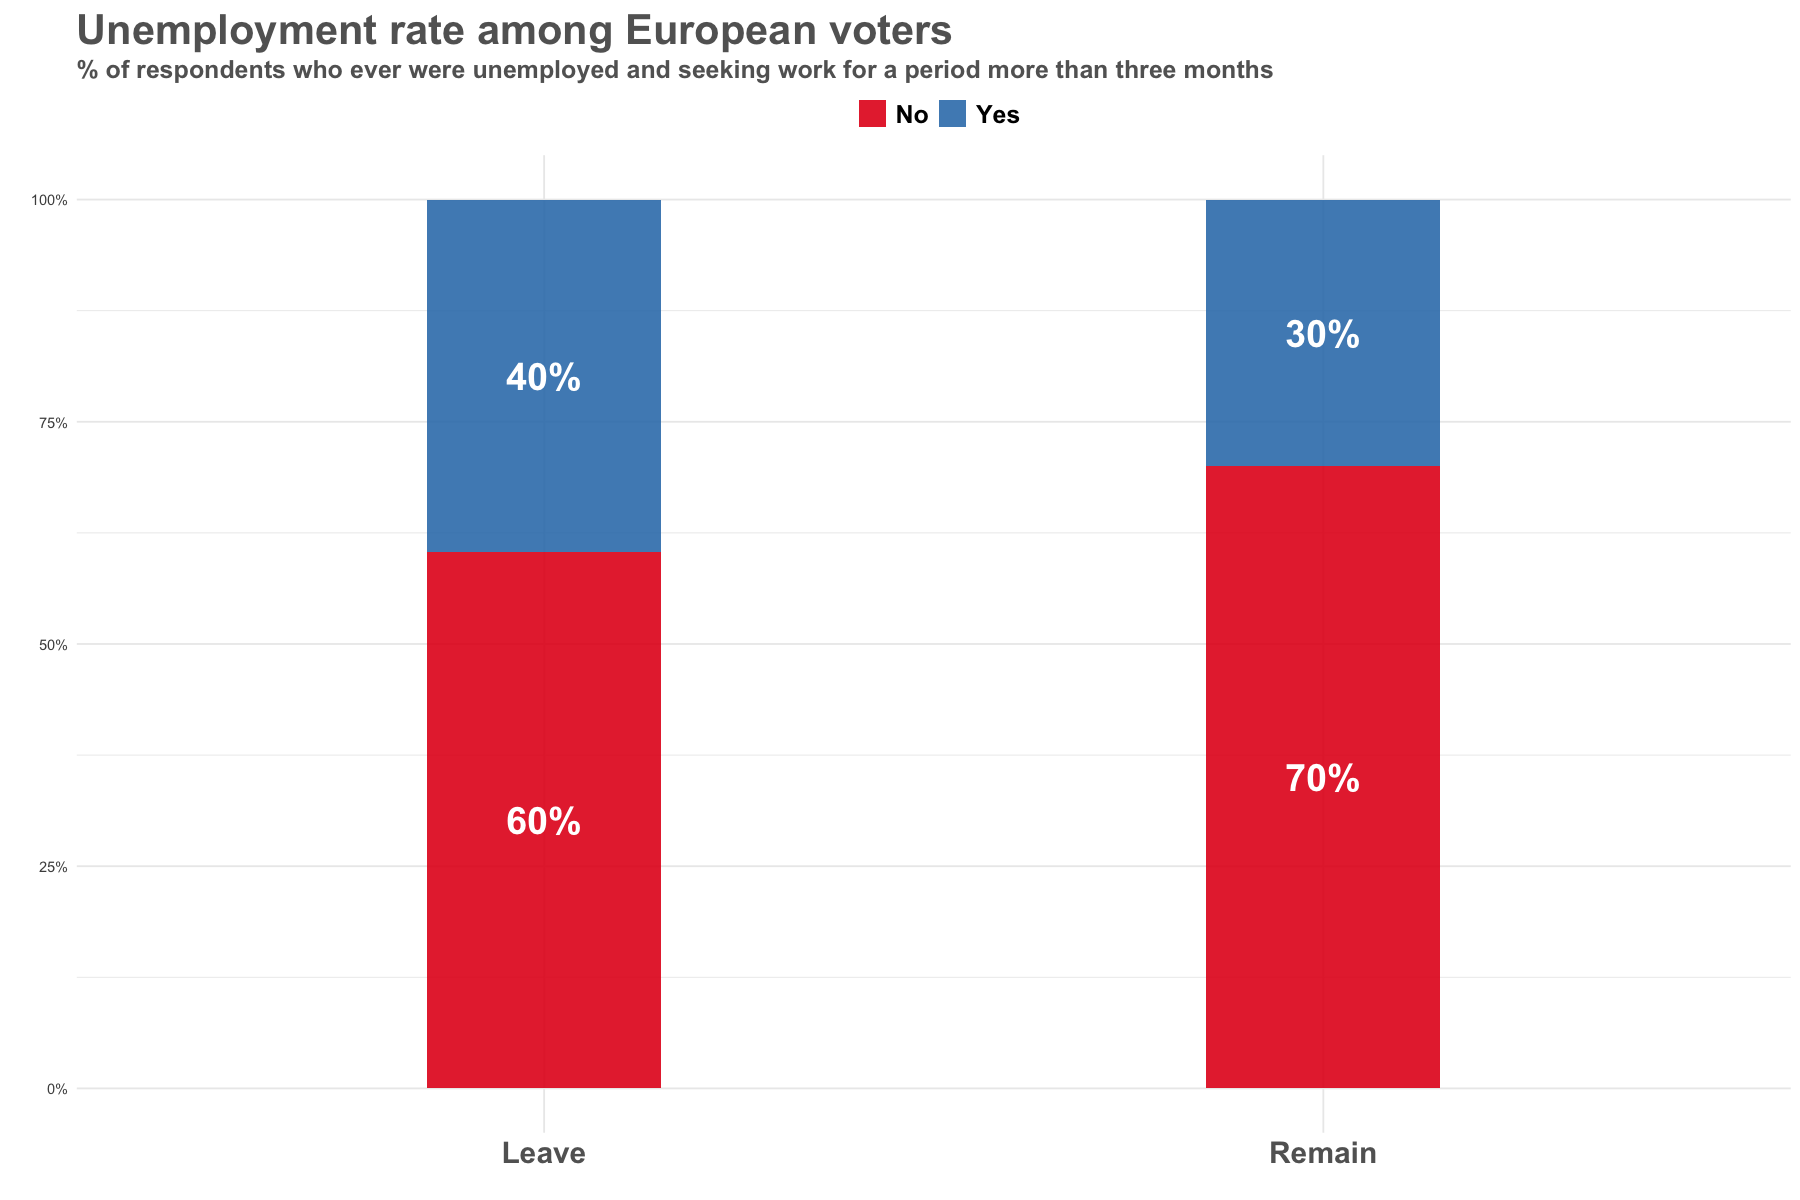

In [39]:
weighted_df_ess %>% 
    group_by(vteurmmb,uemp3m) %>%
    summarise(total = round(survey_total(),2), proportion = survey_mean()) %>%
    mutate(label = paste0(round(proportion * 100, 0), "%"), 
           label_y = cumsum(proportion) - 0.5 * proportion) %>%
    ggplot(aes(x= factor(vteurmmb), y=proportion)) + 
    geom_bar(aes(fill=uemp3m), position = position_stack(reverse = TRUE),
             stat="identity", width = .3, alpha= .9) +
    scale_fill_brewer(palette='Set1') +
    scale_y_continuous(labels = scales::percent) +
    geom_text(aes(y=label_y, label = label), 
              col = "white",
              size = 8,
              fontface = "bold") +
    labs(x = "", y = "", fill = "",
        title = "Unemployment rate among European voters",
        subtitle = "% of respondents who ever were unemployed and seeking work for a period more than three months")+ 
    theme_minimal() + 
    theme(legend.position = "top", 
          legend.direction = "horizontal",
          legend.text = element_text(size=15, face="bold"),
          axis.text.x = element_text(face="bold", color="#636363", size=18),
          plot.title=element_text(vjust=.5,family='', face='bold', colour='#636363', size=25),
          plot.subtitle=element_text(vjust=.5,family='', face='bold', colour='#636363', size=15))


As previously mentioned, countries with a high unemployment rate are probably most affected by the European debt crisis. The unemployment rate impacts directly on citizen's satisfaction with the EU as __40%__ of those with __"Leave-voting intentions"__ have reported being __unemployed recently__.

<a id='4.6'></a>
## Union Membership

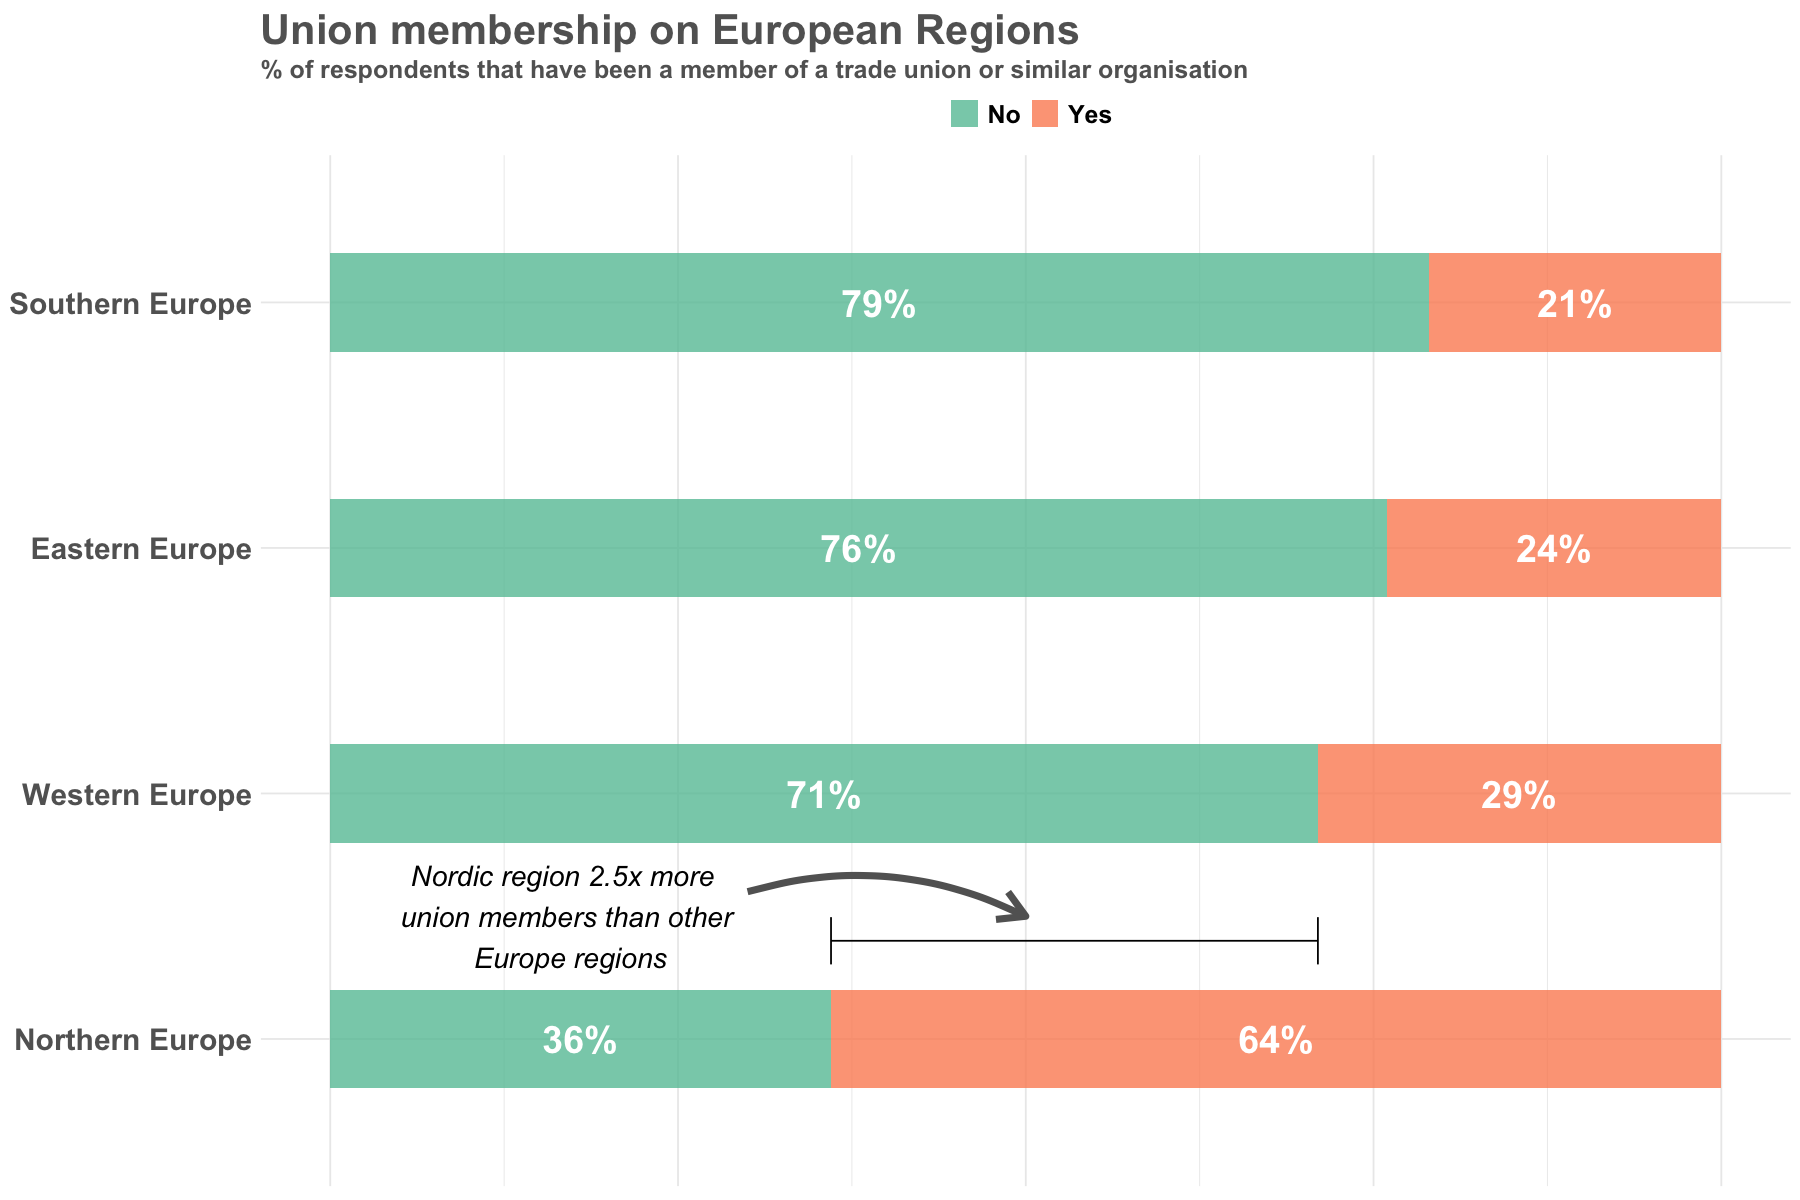

In [40]:
weighted_df_ess %>% 
    group_by(Region,mbtru) %>%
    summarise(total = round(survey_total(),2), proportion = round(survey_mean(),2)) %>%
    mutate(label = paste0(round(proportion * 100, 2), "%"), 
           label_y = cumsum(proportion) - 0.5 * proportion) %>%
    ggplot(aes(x= fct_reorder2(Region, mbtru, proportion, .desc = TRUE), y=proportion)) + 
    geom_bar(aes(fill=mbtru), position = position_stack(reverse = TRUE) ,stat="identity", width = .4,
            alpha= .8) +
    scale_fill_brewer(palette='Set2') +
    scale_y_continuous(labels = scales::percent) +
    coord_flip() +
    geom_text(aes(y=label_y, label = label), col = "white", size = 8, fontface = "bold") +
    annotate("segment", x = 1.4, xend = 1.4, y = .36, yend = .71,
               arrow = arrow(ends = "both", angle = 90, length = unit(.5,"cm"))) +
    annotate("curve", curvature = -.2, x = 1.6, xend =1.5, y = .30, yend = .50,
               colour = "#636363", size = 2, arrow = arrow()) +
    annotate("text", x = 1.5, y = .17, family = "", fontface = 3, size=6,
               label = "Nordic region 2.5x more \n union members than other \n Europe regions") +
    labs(x = "", y = "", fill = "",
        title = "Union membership on European Regions",
        subtitle = "% of respondents that have been a member of a trade union or similar organisation")+ 
    theme_minimal() + 
    theme(legend.position = "top", 
          legend.direction = "horizontal",
          legend.text = element_text(size=15, face="bold"),
          axis.title.x = element_blank(), axis.text.x = element_blank(), axis.ticks.x = element_blank(),
          axis.text.y = element_text(face="bold", color="#636363", size=18),
          axis.title.y = element_blank(),
          plot.title=element_text(vjust=.5,family='', face='bold', colour='#636363', size=25),
          plot.subtitle=element_text(vjust=.5,family='', face='bold', colour='#636363', size=15))

Between 20 and 30% of employees are generally union members in most European Union regions but trade unions play a more important role in __Nordic countries__, showing the __highest union__ density in Europe at __64%__. 

__Why Nordic region has this huge disparity?__ Online research was conducted and the [history of trade unions in the Nordic region](https://nordics.info/show/artikel/trade-unions-in-the-nordic-region/) is very significant, having a huge impact on public policies, especially in labour market and economic issues. This could be also [related to the low unemployment rate](https://nordics.info/show/artikel/trade-union-administered-unemployment-benefit-and-precarious-workers-in-finland/) reported.


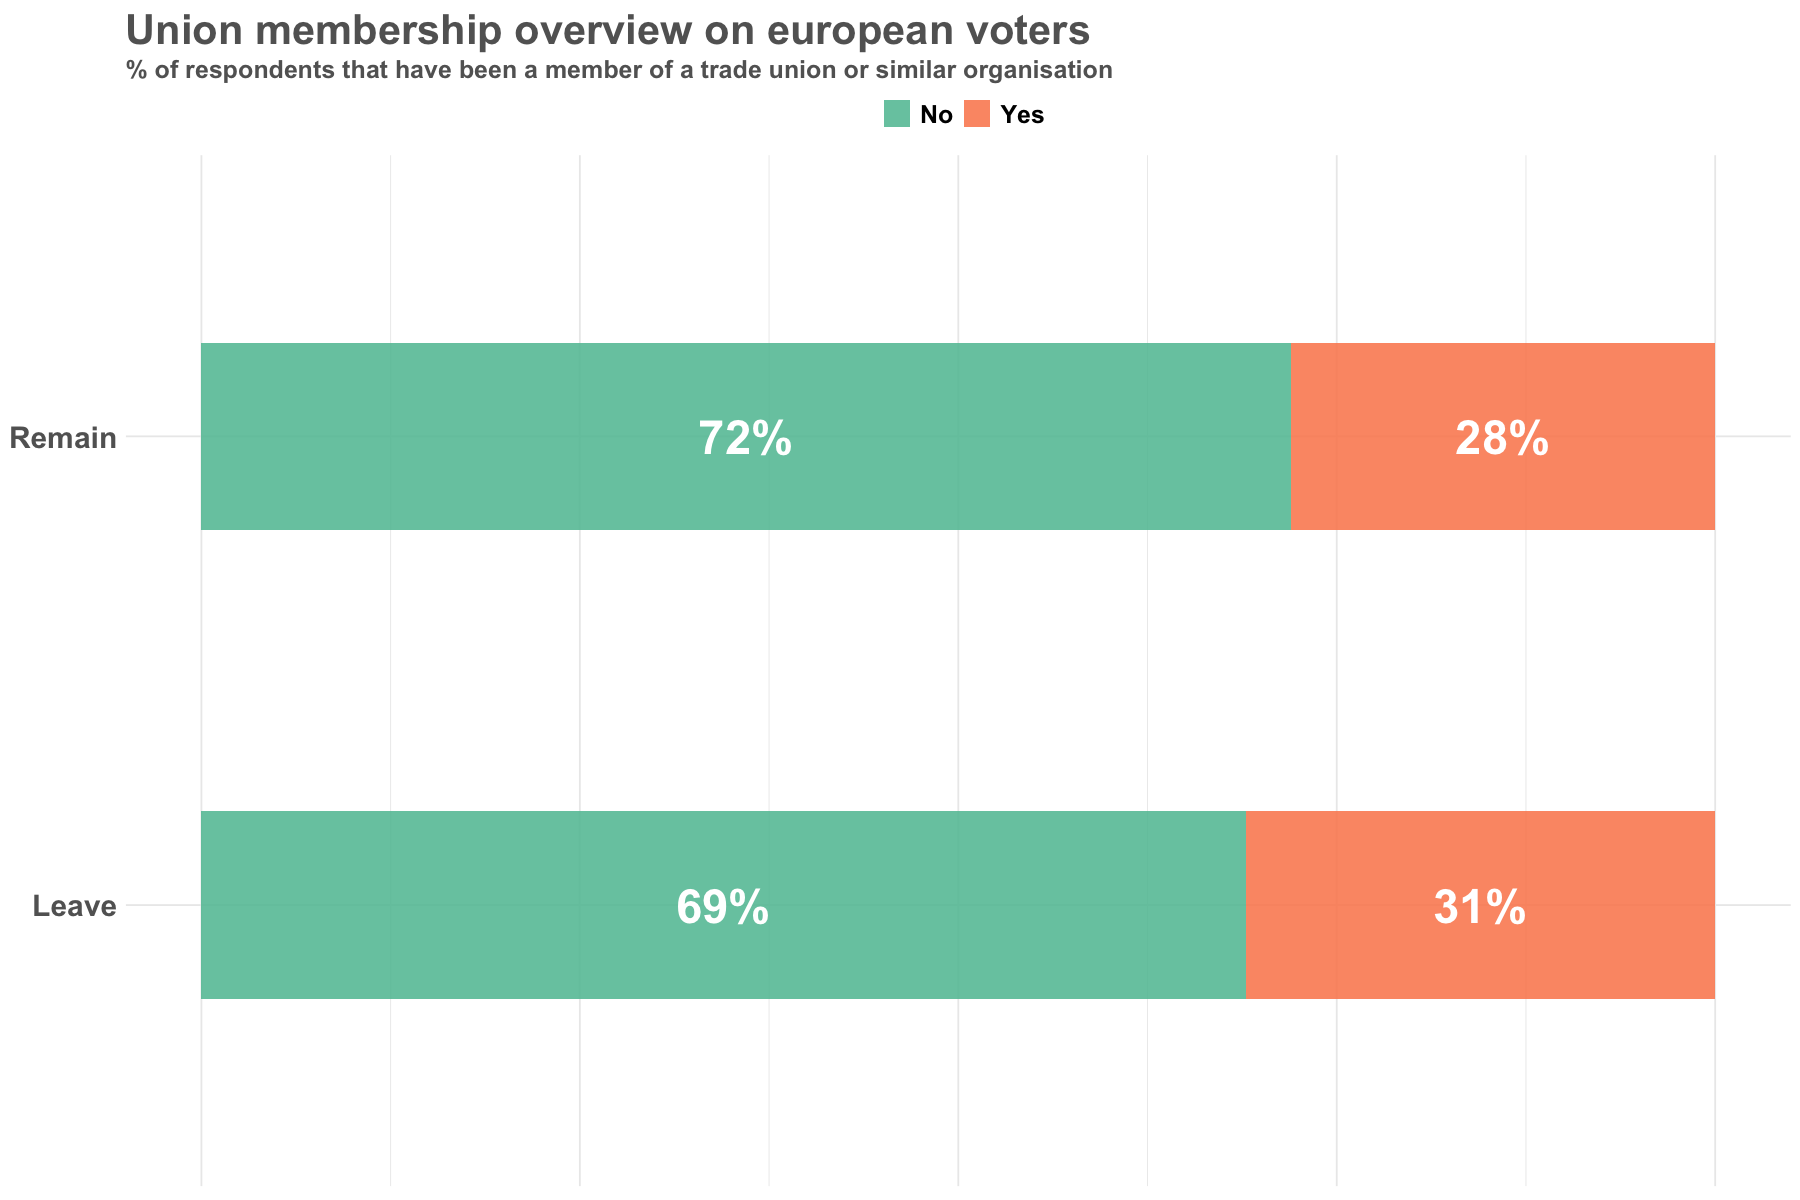

In [41]:
weighted_df_ess %>% 
    group_by(vteurmmb,mbtru) %>%
    summarise(total = round(survey_total(),2), proportion = round(survey_mean(),2)) %>%
    mutate(label = paste0(round(proportion * 100, 2), "%"), 
           label_y = cumsum(proportion) - 0.5 * proportion) %>%
    ggplot(aes(x= vteurmmb, y=proportion)) + 
    geom_bar(aes(fill=mbtru), position = position_stack(reverse = TRUE) ,stat="identity", width = .4, alpha= .9) +
    scale_fill_brewer(palette='Set2') +
    scale_y_continuous(labels = scales::percent) +
    coord_flip() +
    geom_text(aes(y=label_y, label = label), col = "white", size = 10, fontface = "bold") +
    labs(x = "", y = "", fill = "",
        title = "Union membership overview on european voters",
        subtitle = "% of respondents that have been a member of a trade union or similar organisation")+ 
    theme_minimal() + 
    theme(legend.position = "top", 
          legend.direction = "horizontal",
          legend.text = element_text(size=15, face="bold"),
          axis.title.x = element_blank(), axis.text.x = element_blank(), axis.ticks.x = element_blank(),
          axis.text.y = element_text(face="bold", color="#636363", size=18),
          axis.title.y = element_blank(),
          plot.title=element_text(vjust=.5,family='', face='bold', colour='#636363', size=25),
          plot.subtitle=element_text(vjust=.5,family='', face='bold', colour='#636363', size=15))

When it comes to whether __voting intentions__ can be __elucidated by union membership__, it appears to __not be influential__ as the proportions are almost equally distributed (__31% for "Leave intentions"__ and __28% for "Remain intentions"__).

<a id="5"></a>
# <p style="background-color:#003399; font-family:tahoma; font-size:120%; text-align:left; color:#FFCC00; padding: 15px 5px 15px 25px; border-radius: 15px;">5- Relation between Education and Voting Intentions</p>

In __logistic regression__, the dependent variable is binary, i.e. it only contains data marked as __1 (Default)__ or __0 (No default)__. The dependent variable "_vteurmmb_" needs to reflect the default 1 as the vote being to _Leave_ to fit the Generalized Linear Model. For that reason, an adjustment on the variable levels is needed.

<a id='5.1'></a>
## Logistic Regression

In [42]:
# Setting Remain in variable vteurmmb as the first factor level
# Applying this transformation in order to use Remain as 0 and Leave as 1-Default
weighted_df_ess$variables$vteurmmb <- relevel(weighted_df_ess$variables$vteurmmb, ref="Remain")

str(weighted_df_ess$variables)

tibble [32,284 × 15] (S3: tbl_df/tbl/data.frame)
 $ cntry    : Factor w/ 29 levels "Austria","Belgium",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ eduyrs   : num [1:32284] 13 13 13 12 9 14 13 12 13 13 ...
 $ eisced   : Factor w/ 7 levels "ES-ISCED I , less than lower secondary",..: 4 4 2 4 2 4 4 4 4 4 ...
 $ uemp3m   : Factor w/ 2 levels "No","Yes": 1 1 1 1 1 1 2 1 1 2 ...
 $ mbtru    : Factor w/ 2 levels "No","Yes": 1 2 1 1 1 2 2 1 1 1 ...
 $ vteurmmb : Factor w/ 2 levels "Remain","Leave": 1 1 2 1 1 1 1 2 2 1 ...
 $ yrbrn    : Factor w/ 77 levels "1928","1929",..: 48 24 51 28 20 27 35 17 54 43 ...
 $ agea     : num [1:32284] 29 53 26 49 57 50 42 60 23 34 ...
 $ gndr     : Factor w/ 2 levels "Male","Female": 1 1 2 1 2 1 1 2 1 1 ...
 $ anweight : num [1:32284] 0.0659 0.1249 0.6858 0.1168 0.3118 ...
 $ psu      : num [1:32284] 1688 88 938 1998 601 ...
 $ stratum  : num [1:32284] 59 79 11 74 99 77 36 69 9 82 ...
 $ Education: Factor w/ 3 levels "High Education",..: 3 3 2 3 2 3 3 3 3 3 ...
 $ Age_Band 

In [43]:
glm_eduyears_vote <- svyglm(vteurmmb ~ eduyrs, design=weighted_df_ess, family=binomial(link="logit"))

### As the years of formal education increase, the Europeans view towards the EU becomes positive or negative?

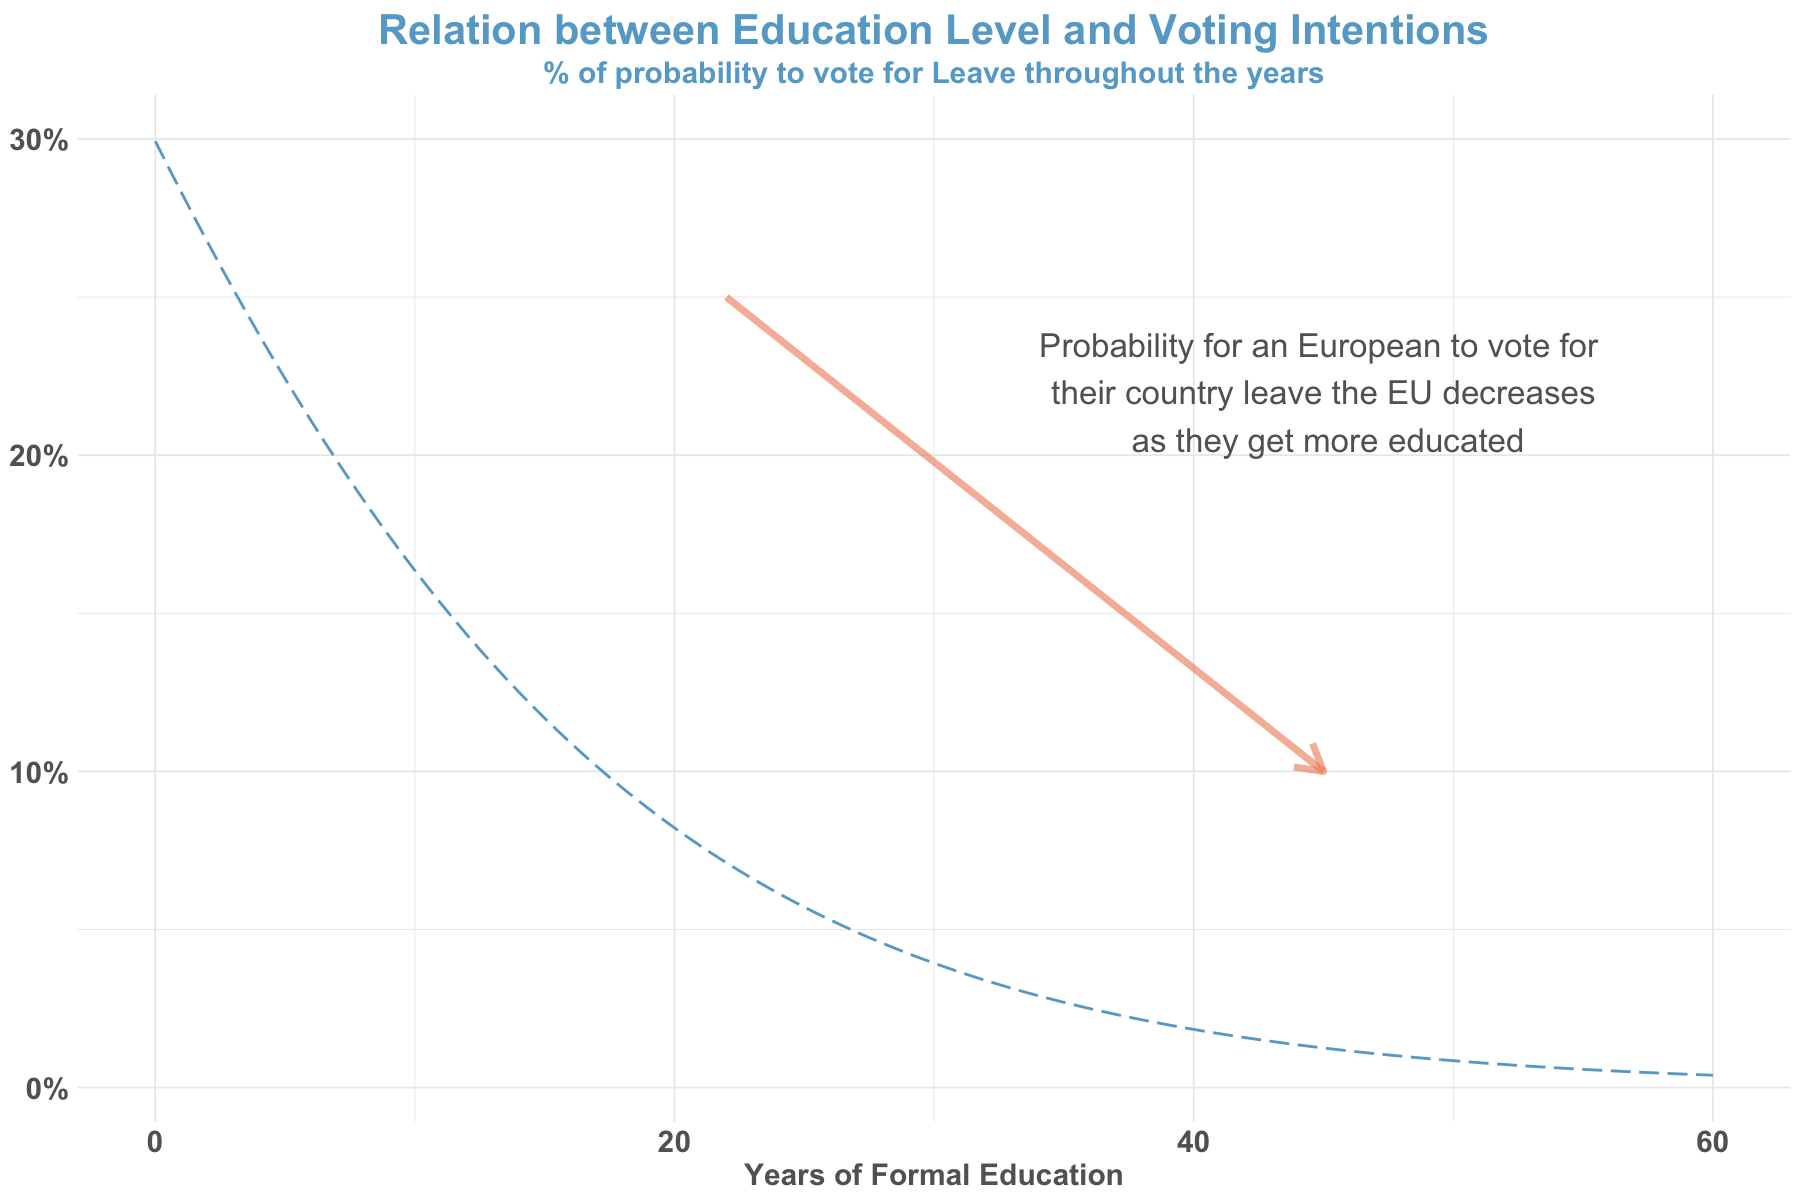

In [44]:
educational_profile <- data.frame(eduyrs = seq(from = 0, to = 60, by = .5))

educational_profile$predicted_probs <- predict(glm_eduyears_vote, 
                                              newdata = educational_profile, 
                                              type = "response")

ggplot(data=educational_profile, aes(x= eduyrs, y=predicted_probs)) + 
geom_line(color="#67a9cf", linetype ="longdash", size = .8) +
scale_fill_brewer(palette='Set1') +
scale_y_continuous(labels = scales::percent) +
annotate("segment", x = 22, xend = 45, y = .25, yend = .10, alpha= .6,
           colour = "#ef8a62", size = 2, arrow = arrow()) +
annotate("text", x = 45, y = .22, family='', face='bold', colour='#636363', size=7,
        label = "Probability for an European to vote for \n their country leave the EU decreases \n as they get more educated") +
labs(x = "Years of Formal Education", y = "Probability to vote for Leave",
    title = "Relation between Education Level and Voting Intentions",
    subtitle = "% of probability to vote for Leave throughout the years")+ 
theme_minimal() + 
theme(axis.text.x = element_text(face="bold", color="#636363", size=18),
      axis.title.x = element_text(face="bold", color="#636363", size=18),
      axis.text.y = element_text(face="bold", color="#636363", size=18),
      axis.title.y = element_blank(),
      plot.title=element_text(vjust=.5,hjust=.5,family='', face='bold', colour='#67a9cf', size=25),
      plot.subtitle=element_text(vjust=.5,hjust=.5,family='', face='bold', colour='#67a9cf', size=18))

Voters __Education levels__ and __happiness__ towards the Brussels-based institution are __statistically correlated__. 

<a id='5.2'></a>
## Predicted probability of voting to _Leave_ the EU

Using a logistic regression model is possible to get interesting insights using a __"voter profile"__ to predict the probability of their vote to be for Leave the EU. The selected independent variables are Unemployment Status, Union membership status and Education level.

In [46]:
glm_voters <- svyglm(vteurmmb ~ uemp3m+mbtru+Education, design=weighted_df_ess, family=binomial(link="logit"))
summary(glm_voters, df.resid = degf(weighted_df_ess))


Call:
svyglm(formula = vteurmmb ~ uemp3m + mbtru + Education, design = weighted_df_ess, 
    family = binomial(link = "logit"))

Survey design:
Called via srvyr

Coefficients:
                          Estimate Std. Error t value Pr(>|t|)    
(Intercept)               -2.98490    0.07970 -37.452  < 2e-16 ***
uemp3mYes                  0.40852    0.05621   7.268 3.85e-13 ***
mbtruYes                   0.21420    0.05978   3.583  0.00034 ***
EducationLow Education     1.09297    0.09146  11.950  < 2e-16 ***
EducationMedium Education  0.98908    0.08156  12.127  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1.002197)

Number of Fisher Scoring iterations: 5


__Since the p-value for all the variables <0.05, hence they are statistically significant at 95% CI.__

### What's the probability that a person with Medium Education level, have been unemployed and is/was a Union member to vote for your country to Leave the EU?

In [47]:
person1 <- predict(glm_voters,
                   newdata = data.frame(Education = "Medium Education", 
                                        uemp3m = "Yes", 
                                        mbtru = "Yes"),
                   type = "response")

paste0(round(person1*100,1), "%")

[1] "20.2%"

### And what about a person with High Education level, that never has been unemployed and is not a Union member to vote for your country to Leave the EU?

In [48]:
person2 <- predict(glm_voters,
                   newdata = data.frame(Education = "High Education", 
                                        uemp3m = "No", 
                                        mbtru = "No"),
                   type = "response")

paste0(round(person2*100,1), "%")

[1] "4.8%"

<a id="6"></a>
# <p style="background-color:#003399; font-family:tahoma; font-size:120%; text-align:left; color:#FFCC00; padding: 15px 5px 15px 25px; border-radius: 15px;">6- Conclusion</p>

The analysis has demonstrated that most of the surveyed countries are happy with the EU, as 68% manifested positive views and 32% not so pleased. Some regions have more positive views than others and, Southern European countries have more positive views towards the EU.

In addition to that, younger Europeans are happier than their older counterparts showing that only 9.5% of young citizens (ages 20 and younger) have a negative view of the EU.

The unemployment rate in Southern Region has presented higher where countries were more affected by the debt crisis. Additionally, unemployed voters are more inclined to vote for their country to leave the EU as 40% of unhappy respondents were unemployed at some point and, 30% of happy voters have never been unemployed. Hungary on the contrary, after the creation of a new labor program, has lowered the unemployment rate to an incredible 13%.

Union membership did not show to play an important role in influencing European voters. However, a significant discovery was spotted showing that Nordic countries have the highest union density in Europe at 64%.

In an educational context, the High education level is 14% higher than those with Remain-voting intention. The medium Education levels represent more than 50% and, Low and Medium Education levels are the vast majority representing 90% of those voters.

Finally, a Logistic Regression model helped to investigate the relationship between Education levels and voting intentions. The outcome, as expected, showed that educated Europeans are generally keener on the EU, which reinforces that the probability for a European to vote for their country to leave the EU decreases as they get more educated.

<a id="7"></a>
# <p style="background-color:#003399; font-family:tahoma; font-size:120%; text-align:left; color:#FFCC00; padding: 15px 5px 15px 25px; border-radius: 15px;">7- References</p>

>Lumley, T. (2010). Complex Surveys: A Guide to Analysis Using R (1st ed.). Hoboken, New Jersey: Wiley.

>Kaminska, O., & Lynn, P. (2017). Survey-Based Cross-Country Comparisons Where Countries Vary in Sample Design: Issues and Solutions. Retrieved March 31, 2021, from https://sciendo.com/article/10.1515/jos-2017-0007

>European Social Survey Cumulative File, ESS 1-9 (2020). Data file edition 1.1. NSD - Norwegian Centre for Research Data, Norway - Data Archive and distributor of ESS data for ESS ERIC.

>International Standard Classification of Education (ISCED) - Statistics Explained. (2020). Retrieved from https://ec.europa.eu/eurostat/statistics-explained/index.php/International_Standard_Classification_of_Education_(ISCED)

>CNN Editorial Research. (2021, January 14). European Debt Crisis Fast Facts. Retrieved from https://edition.cnn.com/2013/07/27/world/europe/european-debt-crisis-fast-facts/index.html

>About Hungary - New labor program significantly cuts Hungary’s unemployment rate. (2019). Retrieved from http://abouthungary.hu/news-in-brief/new-labor-program-significantly-cuts-hungarys-unemployment-rate/

>Logue, J. (2019). Trade unions in the Nordic countries. Retrieved from https://nordics.info/show/artikel/trade-unions-in-the-nordic-region/

>K SHIN, Y. O. U. N. G., & BÖCKERMAN, P. E. T. R. I. (2020). Trade union-administered unemployment benefit and precarious workers in Finland. Retrieved from https://nordics.info/show/artikel/trade-union-administered-unemployment-benefit-and-precarious-workers-in-finland/



<img title="GitHub Mark" src="https://github.com/pessini/european-voters/blob/main/img/GitHub-Mark-64px.png?raw=true" style="height: 32px; padding-right: 15px" alt="GitHub Mark" align="left"> [GitHub repository](https://github.com/pessini/european-voters) <br>Author: Leandro Pessini